# Plotting code

## Initialization - run only once!

In [1]:
from glob import glob
from math import sqrt
from os.path import exists
from typing import Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from matplotlib import pyplot as plt
from tqdm import tqdm
import os, re, sys

sys.path.insert(0, "../")
os.chdir("../")

from graph_analysis.metrics import Subgraphing
from graph_completion.experiments import ExperimentHpars
from graph_completion.graphs.load_graph import LoaderHpars
from graph_completion.utils import reproduce

sns.set(context="paper", font="serif", font_scale=5, style="darkgrid")

In [2]:
def parse_baseline_metrics(dataset: str, algorithm: str) -> Tuple[float, float, float, float, float]:
    if algorithm == "KBGAT":
        return kbgat_baselines[dataset]
    with open(f"graph_completion/results_baseline/{algorithm}_{dataset}_0/train.log",
              mode="r", encoding="utf-8") as baseline_log_file:
        baseline_log = baseline_log_file.read().splitlines()
        baseline_hits_at_1 = float(baseline_log[-3].split(" ")[-1])
        baseline_hits_at_3 = float(baseline_log[-2].split(" ")[-1])
        baseline_hits_at_10 = float(baseline_log[-1].split(" ")[-1])
        baseline_mr = float(baseline_log[-4].split(" ")[-1])
        baseline_mrr = float(baseline_log[-5].split(" ")[-1])
    return baseline_hits_at_1, baseline_hits_at_3, baseline_hits_at_10, baseline_mr, baseline_mrr


def calculate_community_method_metrics(subgraphing: Subgraphing):
    communities = subgraphing.metric_values["DisjointCommunityMembership"][-1]
    num_communities = int(subgraphing.metric_values['DisjointCommunityNumber'][-1])
    community_sizes = np.rint(
        dataset_loader.num_nodes * subgraphing.metric_values["DisjointCommunitySizeDist"][-1][:num_communities]
    ).astype(int)
    c_s = communities[dataset_loader.test_edge_data.s]
    c_t = communities[dataset_loader.test_edge_data.t]

    test_edges_communities = c_t[np.argsort(num_communities * c_t + c_s)]
    com_test_edges = dataset_loader.test_edge_data.assign(c_t=c_t).groupby("c_t").size().reindex(
        np.arange(num_communities), fill_value=0
    ).values
    std_community_sizes, std_com_test_edges = np.std(community_sizes), np.std(com_test_edges)
    cut_size = subgraphing.metric_values['DisjointCommunityCutSize'][-1]
    modularity = subgraphing.metric_values['DisjointCommunityModularity'][-1]
    speed_up = ((N[dataset_key] * V_size[dataset_key])
                / ((num_communities + community_sizes) * com_test_edges).sum())
    inter_community_edges = (communities[dataset_loader.dataset.edge_data.s]
                             != communities[dataset_loader.dataset.edge_data.t])
    inter_community_nodes = np.unique(np.concatenate((
        dataset_loader.dataset.edge_data[inter_community_edges].s.values,
        dataset_loader.dataset.edge_data[inter_community_edges].t.values)
    ))
    bulk_up = (V_size[dataset_key] + num_communities + len(inter_community_nodes) + 1) / V_size[dataset_key]
    return ((std_community_sizes, std_com_test_edges, cut_size, modularity, speed_up, bulk_up),
            (test_edges_communities, com_test_edges))

In [3]:
datasets_names = {"freebase": "FB15k-237", "wordnet": "WN18RR", "nell": "NELL-995"}
algs_names = {"transe": "TransE", "distmult": "DistMult",
              "complex": "ComplEx", "rotate": "RotatE", 
              "kbgat": "KBGAT", "q2b": "Query2Box"}
kbgat_baselines = {"freebase": (0.46, 0.54, 0.626, 210, 0.518),
                   "wordnet": (0.361, 0.483, 0.581, 1940, 0.440),
                   "nell": (0.447, 0.564, 0.695, 965, 0.530)}
vanilla_seed_options = {"freebase": 4089853924, "wordnet": 1919180054, "nell": 3192206669}
random_seed_options = {"freebase": 123456789, "wordnet": 627997250, "nell": 3192206669}
all_seeds = {('freebase', 'transe'): [4089853924, 227235523, 2326762024, 3575923668, 2242653281], ('freebase', 'distmult'): [3840659425, 2337116793, 2593788844, 346226564, 2908850781], ('freebase', 'complex'): [284111598, 123456789, 1721625950, 3955541379, 855187505], ('freebase', 'rotate'): [1908872794, 1864961672, 2315221302, 1098412517, 4290110103], ('freebase', 'kbgat'): [123456789, 3620020537, 2871187237, 4150596743, 2401012176], ('freebase', 'q2b'): [3068392341, 1503136574, 2561231356], ('wordnet', 'transe'): [1919180054, 3360164579, 249702977, 3032421329, 2516490325], ('wordnet', 'distmult'): [2452280894, 3533409554, 4002363330, 4268288083, 3273385450], ('wordnet', 'complex'): [2894376728, 945798902, 1822472063, 4064912856, 1523787398], ('wordnet', 'rotate'): [1461983073, 34227865, 2214881675, 709014113, 4239039334], ('wordnet', 'kbgat'): [123456789, 3496329302, 2199533396, 225662736, 2017591622], ('wordnet', 'q2b'): [1127470567, 2876003130, 3312854056], ('nell', 'transe'): [3192206669, 2850977416, 4141475287, 3587571461, 935486682], ('nell', 'distmult'): [387280847, 2901918027, 231199377, 3677172184, 3194848579], ('nell', 'complex'): [1081569530, 2409194445, 2536776501, 1567286030, 502047518], ('nell', 'rotate'): [778161351, 3855380893, 731912373, 1628033024, 2525047864], ('nell', 'kbgat'): [123456789, 2361146985, 2989389321, 337117137, 1260496497], ('nell', 'q2b'): [1782600322, 3839473830, 3793326028]}

## Community detection simulations

In [4]:
num_leiden_samples, num_random_samples = 1000, 100
N, K, V_size, V_star_size, total_eval_embeddings = dict(), dict(), dict(), dict(), dict()
nodepiece_A, nodepiece_k = {"freebase": 1000, "wordnet": 500}, {"freebase": 20, "wordnet": 50}
earl_E_res, earl_k = {"freebase": 1450, "wordnet": 4055}, {"freebase": 10, "wordnet": 10}

datasets_resolution, datasets_cut_size, datasets_modularity = dict(), dict(), dict()
datasets_speed_up, datasets_bulk_up = dict(), dict()
datasets_test_edges_communities, datasets_com_test_edges = dict(), dict()
datasets_test_edges_communities_extra, datasets_com_test_edges_extra = dict(), dict()
datasets_test_edges_communities_kbgat, datasets_com_test_edges_kbgat = dict(), dict()
datasets_train_edges = dict()
leiden_resolution_scales = np.logspace(-5, 5, num_leiden_samples)
leiden_resolution_scales_extra = np.array([1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
plot_data_leiden = []
plot_data_leiden_extra = []
plot_data_metis = []
plot_data_random = []
for dataset_key, dataset_name in datasets_names.items():
    with open(f"graph_completion/configs/{dataset_key}.yml", "r", encoding="utf-8") as config_file:
        dataset_conf = ExperimentHpars.from_dict(yaml.safe_load(config_file)).make()
    reproduce(vanilla_seed_options[dataset_key])
    dataset_loader = LoaderHpars.from_dict(dataset_conf.loader_hpars).make()
    dataset_loader.load_graph(vanilla_seed_options[dataset_key], "cpu",
                              dataset_conf.val_size, dataset_conf.test_size,
                              dataset_conf.community_method, dataset_conf.leiden_resolution)
    N[dataset_key] = len(dataset_loader.test_edge_data)
    K[dataset_key] = dataset_loader.num_communities
    V_size[dataset_key] = dataset_loader.num_nodes
    V_star_size[dataset_key] = dataset_loader.inter_community_map.max()
    c_s = dataset_loader.communities[dataset_loader.test_edge_data.s]
    c_t = dataset_loader.communities[dataset_loader.test_edge_data.t]

    datasets_test_edges_communities[dataset_key] = c_t[np.argsort(dataset_loader.num_communities * c_s + c_t)]
    com_test_edges = dataset_loader.test_edge_data.assign(c_t=c_t).groupby("c_t").size().reindex(
        np.arange(dataset_loader.num_communities), fill_value=0
    ).values
    datasets_com_test_edges[dataset_key] = com_test_edges
    com_test_embeddings = dataset_loader.num_communities + dataset_loader.community_sizes
    total_eval_embeddings[dataset_key] = (com_test_edges * com_test_embeddings).sum()
    speed_up = (N[dataset_key] * V_size[dataset_key]) / total_eval_embeddings[dataset_key]
    bulk_up = (V_size[dataset_key] + K[dataset_key] + V_star_size[dataset_key] + 1) / V_size[dataset_key]
    for alg_key in ["transe", "distmult", "complex", "rotate"]:
        for seed in all_seeds[dataset_key, alg_key]:
            datasets_speed_up[dataset_key, alg_key, seed] = speed_up
            datasets_bulk_up[dataset_key, alg_key, seed] = bulk_up
    datasets_train_edges[dataset_key] = dataset_loader.num_train_edges

    subgraphing = Subgraphing(dataset_loader.graph, dataset_loader.num_nodes, "leiden", dataset_conf.leiden_resolution)
    subgraphing.recursive_updates(dataset_loader.dataset.node_data, dataset_loader.dataset.edge_data)
    subgraphing.compute_metrics()
    datasets_resolution[dataset_key] = subgraphing.community_resolution_disjoint
    datasets_cut_size[dataset_key] = subgraphing.metric_values['DisjointCommunityCutSize'][-1]
    datasets_modularity[dataset_key] = subgraphing.metric_values['DisjointCommunityModularity'][-1]

    reproduce(123456789)
    subgraphing.recursive_updates(dataset_loader.dataset.node_data, dataset_loader.dataset.edge_data)
    subgraphing.compute_metrics()
    (_, _, _, _, speed_up, bulk_up), (test_edges_communities, com_test_edges) = calculate_community_method_metrics(subgraphing)
    datasets_test_edges_communities_kbgat[dataset_key] = test_edges_communities
    datasets_com_test_edges_kbgat[dataset_key] = com_test_edges
    print(f"Acceleration for {datasets_names[dataset_key]}: {round(speed_up, 4)}")
    print(f"Overparametrization for {datasets_names[dataset_key]}: {round(bulk_up, 4)}")
    for seed in all_seeds[dataset_key, "kbgat"]:
        datasets_speed_up[dataset_key, "kbgat", seed] = speed_up
        datasets_bulk_up[dataset_key, "kbgat", seed] = bulk_up
    for seed in all_seeds[dataset_key, "q2b"]:
        reproduce(seed)
        subgraphing.recursive_updates(dataset_loader.dataset.node_data, dataset_loader.dataset.edge_data)
        subgraphing.compute_metrics()
        (_, _, _, _, speed_up, bulk_up), _ = calculate_community_method_metrics(subgraphing)
        datasets_speed_up[dataset_key, "q2b", seed] = speed_up
        datasets_bulk_up[dataset_key, "q2b", seed] = bulk_up


    leiden_resolution_values = subgraphing.community_resolution_disjoint * leiden_resolution_scales
    leiden_resolution_values_extra = subgraphing.community_resolution_disjoint * leiden_resolution_scales_extra
    for leiden_resolution in tqdm(leiden_resolution_values, "Validating Leiden resolution", leave=False):
        reproduce(dataset_conf.seed)
        subgraphing.community_resolution_disjoint = leiden_resolution
        subgraphing.recursive_updates(dataset_loader.dataset.node_data, dataset_loader.dataset.edge_data)
        subgraphing.compute_metrics()
        community_method_metrics, _ = calculate_community_method_metrics(subgraphing)
        plot_data_leiden.append((dataset_key, leiden_resolution, *community_method_metrics))
    for i, leiden_resolution in tqdm(enumerate(leiden_resolution_values_extra),
                                     "Validating Leiden resolution", total=6, leave=False):
        reproduce(vanilla_seed_options[dataset_key] if i == 1 else dataset_conf.seed)
        subgraphing.community_resolution_disjoint = leiden_resolution
        subgraphing.recursive_updates(dataset_loader.dataset.node_data, dataset_loader.dataset.edge_data)
        subgraphing.compute_metrics()
        (community_method_metrics,
         (test_edges_communities, com_test_edges)) = calculate_community_method_metrics(subgraphing)
        datasets_test_edges_communities_extra[
            (dataset_key, ("leiden", leiden_resolution))
        ] = test_edges_communities
        datasets_com_test_edges_extra[(dataset_key, ("leiden", leiden_resolution))] = com_test_edges
        plot_data_leiden_extra.append((dataset_key, leiden_resolution, *community_method_metrics))

    subgraphing.community_method = "metis"
    reproduce(dataset_conf.seed)
    subgraphing.recursive_updates(dataset_loader.dataset.node_data, dataset_loader.dataset.edge_data)
    subgraphing.compute_metrics()
    (community_method_metrics,
     (test_edges_communities, com_test_edges)) = calculate_community_method_metrics(subgraphing)
    datasets_test_edges_communities_extra[
        (dataset_key, ("metis", datasets_resolution[dataset_key]))
    ] = test_edges_communities
    datasets_com_test_edges_extra[(dataset_key, ("metis", datasets_resolution[dataset_key]))] = com_test_edges
    plot_data_metis.append((dataset_key, *community_method_metrics))
    subgraphing.community_method = "random"
    reproduce(random_seed_options[dataset_key])
    for sample_id in tqdm(range(num_random_samples), "Validating random community partition", leave=False):
        subgraphing.recursive_updates(dataset_loader.dataset.node_data, dataset_loader.dataset.edge_data)
        subgraphing.compute_metrics()
        (community_method_metrics,
         (test_edges_communities, com_test_edges)) = calculate_community_method_metrics(subgraphing)
        if sample_id == 0:
            datasets_test_edges_communities_extra[
                (dataset_key, ("random", datasets_resolution[dataset_key]))
            ] = test_edges_communities
            datasets_com_test_edges_extra[
                (dataset_key, ("random", datasets_resolution[dataset_key]))
            ] = com_test_edges
        plot_data_random.append((dataset_key, sample_id, *community_method_metrics))
        
    if dataset_key not in ["freebase", "wordnet"]:
        continue
    datasets_speed_up[dataset_key, "NodePiece-RotatE", 0] = ((N[dataset_key] * V_size[dataset_key]) 
                                                             / (nodepiece_A[dataset_key] 
                                                                + nodepiece_k[dataset_key] 
                                                                * N[dataset_key] * V_size[dataset_key]))
    datasets_speed_up[dataset_key, "EARL-RotatE", 0] = ((N[dataset_key] * V_size[dataset_key]) 
                                                        / (earl_E_res[dataset_key] 
                                                           + (earl_k[dataset_key] 
                                                              * (V_size[dataset_key] - earl_E_res[dataset_key])) 
                                                           * N[dataset_key]))
    
plot_data_leiden = pd.DataFrame(plot_data_leiden, columns=["Dataset", "LeidenResolution",
                                                           "StdCommunitySizes", "StdCommunityNumTestEdges",
                                                           "CutSize", "Modularity",
                                                           "Acceleration", "Overparametrization"])
plot_data_leiden = plot_data_leiden.melt(id_vars=["Dataset", "LeidenResolution",
                                                  "StdCommunitySizes", "StdCommunityNumTestEdges",
                                                  "CutSize", "Modularity"],
                                         value_vars=["Acceleration", "Overparametrization"],
                                         var_name="Factor", value_name="Value")
plot_data_leiden_extra = pd.DataFrame(plot_data_leiden_extra, columns=["Dataset", "LeidenResolution",
                                                                       "StdCommunitySizes",
                                                                       "StdCommunityNumTestEdges",
                                                                       "CutSize", "Modularity",
                                                                       "Acceleration",
                                                                       "Overparametrization"])
plot_data_metis = pd.DataFrame(plot_data_metis, columns=["Dataset",
                                                         "StdCommunitySizes", "StdCommunityNumTestEdges",
                                                         "CutSize", "Modularity",
                                                         "Acceleration", "Overparametrization"])
plot_data_random = pd.DataFrame(plot_data_random, columns=["Dataset", "SampleId",
                                                           "StdCommunitySizes", "StdCommunityNumTestEdges",
                                                           "CutSize", "Modularity",
                                                           "Acceleration", "Overparametrization"])

Loading freebase graph...
Computing required metrics...
Num nodes: 14541
Num edges: 310116
Num node types: 1
Num relations: 237
Edge density: 0.00146668
Node type assortativity: 1.0000
Largest WCC: 0.9992
Largest SCC: 0.8107
Average path length: 3.7964
Diameter: 14
Average clustering: 0.016562
Number of communities: 1092
Largest community: 0.2413
Cut size: 86215
Modularity: 0.4671
Percentage of inter-community nodes: 0.9202
ComHITS@1 upper bound: 0.8580
ComHITS@3 upper bound: 0.9463
ComHITS@10 upper bound: 0.9801
ComMR lower bound: 2.0470
ComMRR upper bound: 0.9059


Acceleration for FB15k-237: 4.3664
Overparametrization for FB15k-237: 1.9926


Loading wordnet graph...
Computing required metrics...
Num nodes: 41105
Num edges: 93003
Num node types: 5
Num relations: 11
Edge density: 0.00005504
Node type assortativity: 0.1965
Largest WCC: 0.9993
Largest SCC: 0.3713
Average path length: 13.7080
Diameter: 41
Average clustering: 0.009660
Number of communities: 66
Largest community: 0.3163
Cut size: 5420
Modularity: 0.7276
Percentage of inter-community nodes: 0.1638
ComHITS@1 upper bound: 0.9420
ComHITS@3 upper bound: 0.9917
ComHITS@10 upper bound: 0.9999
ComMR lower bound: 1.0963
ComMRR upper bound: 0.9666


Acceleration for WN18RR: 4.5833
Overparametrization for WN18RR: 1.156


Loading nell graph...
Computing required metrics...
Num nodes: 75492
Num edges: 154213
Num node types: 269
Num relations: 200
Edge density: 0.00002706
Node type assortativity: 0.1374
Largest WCC: 0.7102
Largest SCC: 0.1128
Average path length: 6.2474
Diameter: 23
Average clustering: 0.007462
Number of communities: 282
Largest community: 0.2588
Cut size: 6470
Modularity: 0.7764
Percentage of inter-community nodes: 0.0648
ComHITS@1 upper bound: 0.9730
ComHITS@3 upper bound: 0.9968
ComHITS@10 upper bound: 0.9999
ComMR lower bound: 1.0421
ComMRR upper bound: 0.9848


Acceleration for NELL-995: 10.2892
Overparametrization for NELL-995: 1.0687


## Community detection metrics vs Scalability metrics

<Figure size 2527.2x597.6 with 0 Axes>

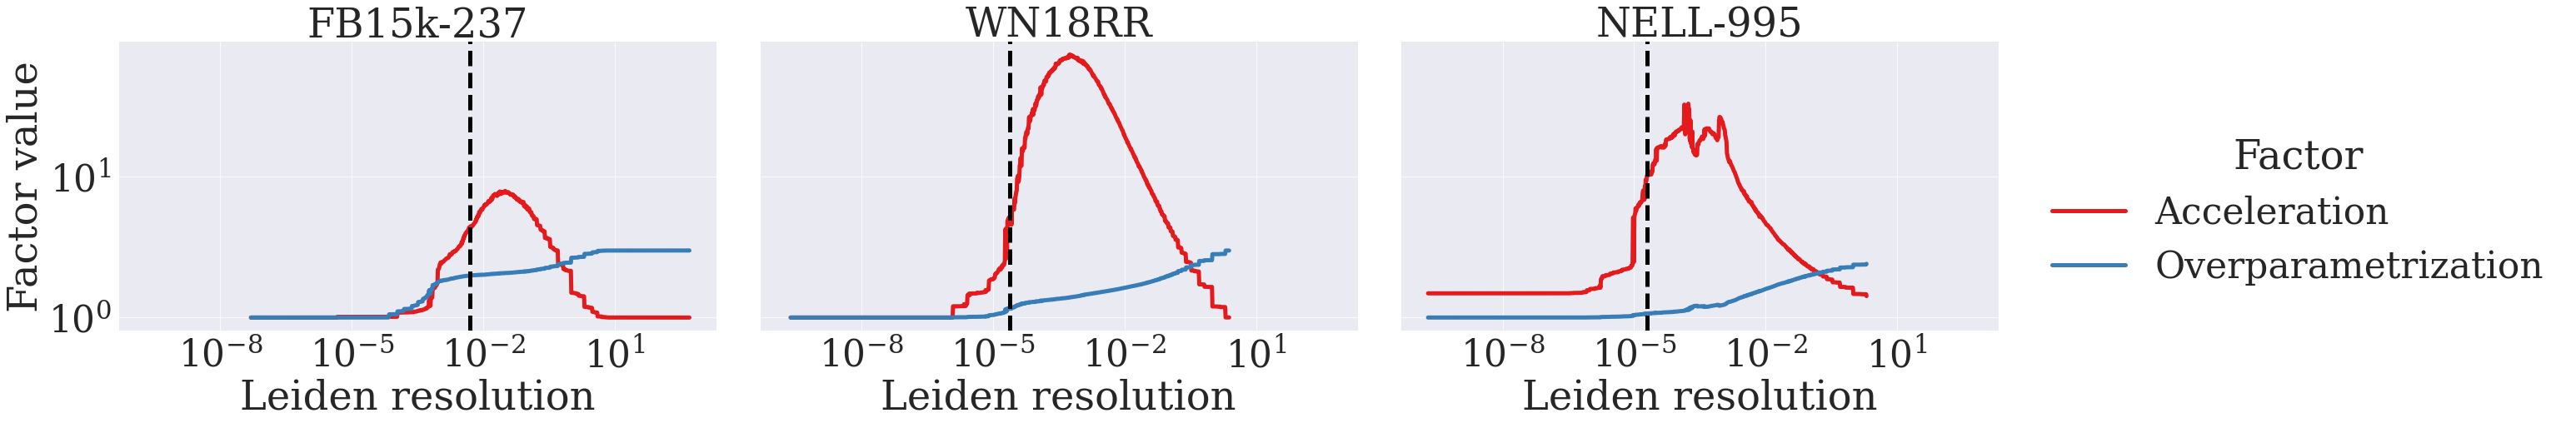

In [5]:
factor_color_map = {factor_name: color for factor_name, color in zip(
    ["speed_up", "bulk_up"], sns.color_palette("Set1", n_colors=len(datasets_names), desat=0.75).as_hex()
)}
plt.figure(figsize=(3 * 11.7, 8.3))
g = sns.relplot(x="LeidenResolution", y="Value", hue="Factor", col="Dataset", data=plot_data_leiden,
                palette="Set1", linewidth=5, kind="line",
                height=8.3, aspect=11.7 / 8.3, facet_kws={"legend_out": True})
for dataset_key, ax in g.axes_dict.items():
    ax.axvline(datasets_resolution[dataset_key], 0, sqrt(V_size[dataset_key]) / 2,
               color="black", linestyle="dashed", lw=5)
    ax.set_title(datasets_names[dataset_key])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Leiden resolution")
    ax.set_ylabel("Factor value")
for lh in g.legend.get_lines():
    lh.set_linewidth(5)
g.tight_layout()
plt.savefig("graph_completion/results/scalability_leiden_resolution.pdf", format="pdf")

<Figure size 2527.2x597.6 with 0 Axes>

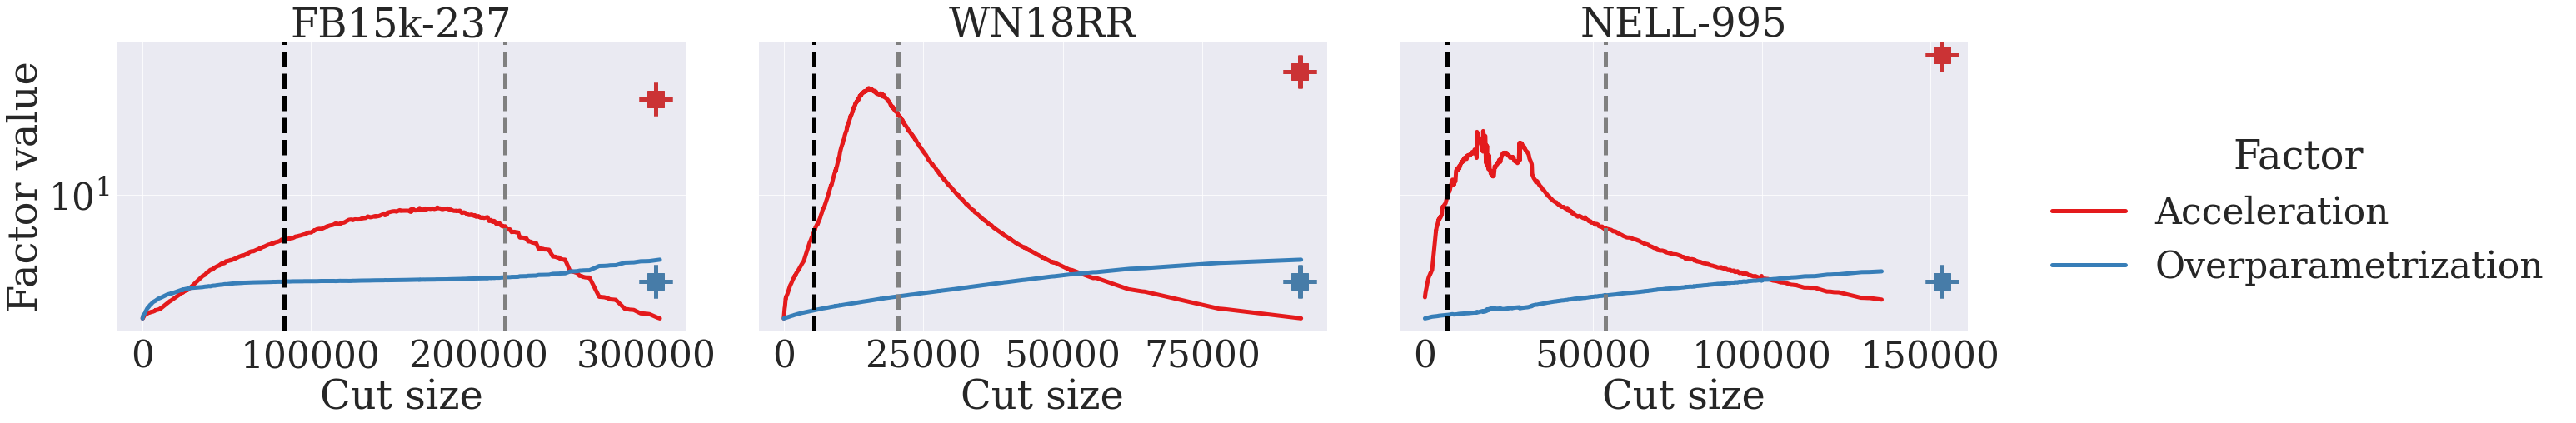

In [6]:
plt.figure(figsize=(3 * 11.7, 8.3))
g = sns.relplot(x="CutSize", y="Value", hue="Factor", col="Dataset", data=plot_data_leiden,
                palette="Set1", linewidth=5, kind="line",
                height=8.3, aspect=11.7 / 8.3, facet_kws={"sharex": False, "legend_out": True})
for dataset_key, ax in g.axes_dict.items():
    ax.axvline(datasets_cut_size[dataset_key], 0, sqrt(V_size[dataset_key]) / 2,
               color="black", linestyle="dashed", lw=5)
    metis_cut_size = plot_data_metis[plot_data_metis.Dataset == dataset_key].CutSize.iloc[0]
    random_cut_size = plot_data_random[plot_data_random.Dataset == dataset_key].CutSize
    random_speed_up = plot_data_random[plot_data_random.Dataset == dataset_key].Acceleration
    random_bulk_up = plot_data_random[plot_data_random.Dataset == dataset_key].Overparametrization
    ax.axvline(metis_cut_size, 0, sqrt(V_size[dataset_key]) / 2, color="gray", linestyle="dashed", lw=5)
    ax.errorbar(x=random_cut_size.mean(), y=random_speed_up.mean(),
                xerr=random_cut_size.std(), yerr=random_speed_up.std(),
                fmt=factor_color_map["speed_up"], ecolor=factor_color_map["speed_up"], marker="s",
                markersize=20, elinewidth=5, capsize=20, capthick=5)
    ax.errorbar(x=random_cut_size.mean(), y=random_bulk_up.mean(),
                xerr=random_cut_size.std(), yerr=random_bulk_up.std(),
                fmt=factor_color_map["bulk_up"], ecolor=factor_color_map["bulk_up"], marker="s",
                markersize=20, elinewidth=5, capsize=20, capthick=5)
    ax.set_title(datasets_names[dataset_key])
    ax.set_yscale("log")
    ax.set_xlabel("Cut size")
    ax.set_ylabel("Factor value")
for lh in g.legend.get_lines():
    lh.set_linewidth(5)
g.tight_layout()
plt.savefig("graph_completion/results/scalability_leiden_cut_size.pdf", format="pdf")

<Figure size 2527.2x597.6 with 0 Axes>

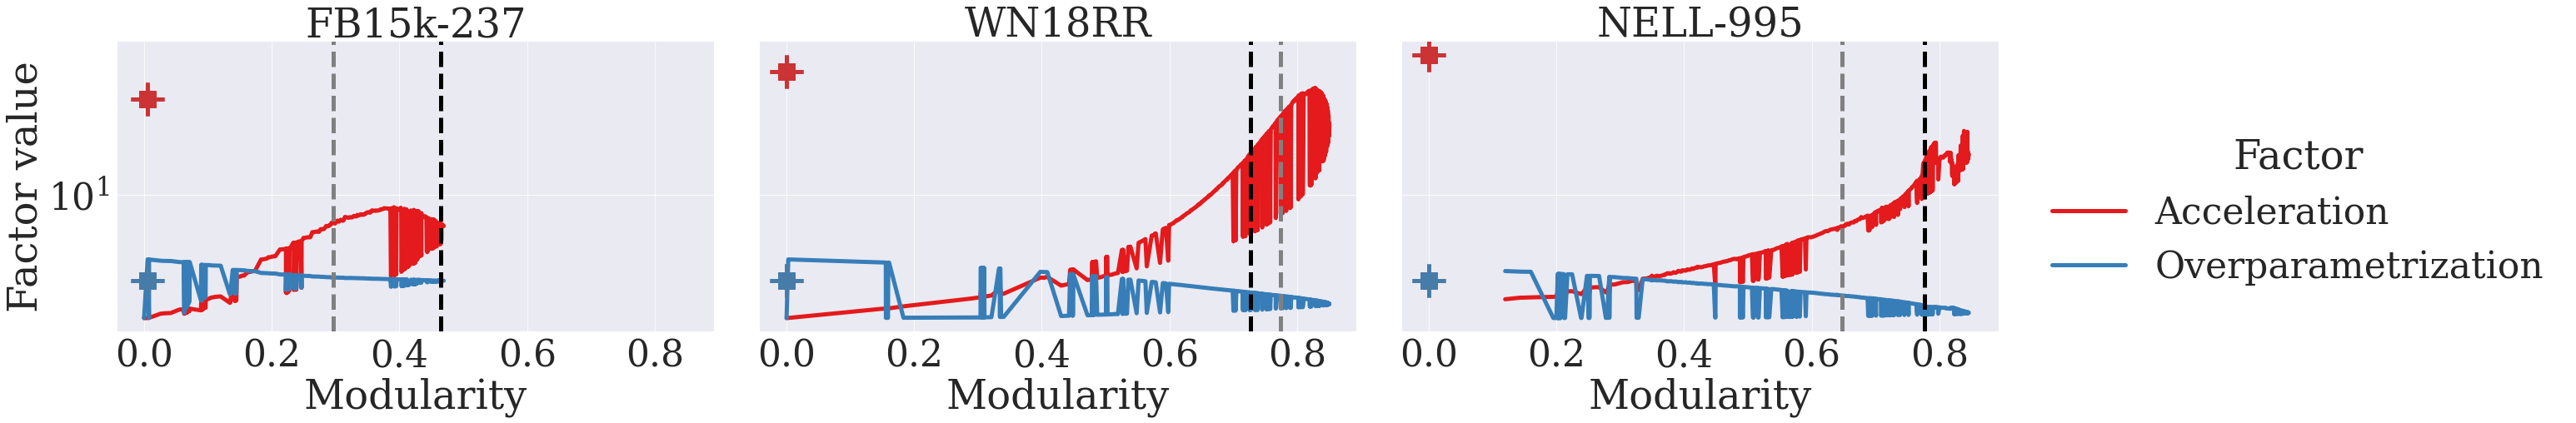

In [7]:
plt.figure(figsize=(3 * 11.7, 8.3))
g = sns.relplot(x="Modularity", y="Value", hue="Factor", col="Dataset", data=plot_data_leiden,
                palette="Set1", linewidth=5, kind="line",
                height=8.3, aspect=11.7 / 8.3, facet_kws={"legend_out": True})
for dataset_key, ax in g.axes_dict.items():
    ax.axvline(datasets_modularity[dataset_key], 0, sqrt(V_size[dataset_key]) / 2,
               color="black", linestyle="dashed", lw=5)
    metis_modularity = plot_data_metis[plot_data_metis.Dataset == dataset_key].Modularity.iloc[0]
    random_modularity = plot_data_random[plot_data_random.Dataset == dataset_key].Modularity
    random_speed_up = plot_data_random[plot_data_random.Dataset == dataset_key].Acceleration
    random_bulk_up = plot_data_random[plot_data_random.Dataset == dataset_key].Overparametrization
    ax.axvline(metis_modularity, 0, sqrt(V_size[dataset_key]) / 2, color="gray", linestyle="dashed", lw=5)
    ax.errorbar(x=random_modularity.mean(), y=random_speed_up.mean(),
                xerr=random_modularity.std(), yerr=random_speed_up.std(),
                fmt=factor_color_map["speed_up"], ecolor=factor_color_map["speed_up"], marker="s",
                markersize=20, elinewidth=5, capsize=20, capthick=5)
    ax.errorbar(x=random_modularity.mean(), y=random_bulk_up.mean(),
                xerr=random_modularity.std(), yerr=random_bulk_up.std(),
                fmt=factor_color_map["bulk_up"], ecolor=factor_color_map["bulk_up"], marker="s",
                markersize=20, elinewidth=5, capsize=20, capthick=5)
    ax.set_title(datasets_names[dataset_key])
    ax.set_yscale("log")
    ax.set_xlabel("Modularity")
    ax.set_ylabel("Factor value")
for lh in g.legend.get_lines():
    lh.set_linewidth(5)
g.tight_layout()
plt.savefig("graph_completion/results/scalability_leiden_modularity.pdf", format="pdf")

## Load result files

In [8]:
train_logs = []
test_logs = []
test_ranks = []
for dataset in datasets_names:
    for run_folder in glob(f"graph_completion/results/{dataset}/runs/*"):
        new_format = re.search("(nell/runs/1[1-5])|(runs/2[6-8])", run_folder)
        if exists(f"{run_folder}/train_log.txt"):
            train_log = pd.read_csv(f"{run_folder}/train_log.txt", sep="\t", encoding="utf-8", header=None)
            if not new_format:
                train_log.insert(4, "CommunityMethod", "leiden")
                train_log.columns = range(41)
            train_logs.append(train_log)
        if exists(f"{run_folder}/test_log.txt"):
            test_log = pd.read_csv(f"{run_folder}/test_log.txt", sep="\t", encoding="utf-8",
                         header=None, index_col=None, dtype={0: str})
            if not new_format:
                test_log.insert(5, "CommunityMethod", "leiden")
                test_log.columns = range(53)
            test_logs.append(test_log)
        if exists(f"{run_folder}/test_ranks.txt"):
            log_file = pd.read_csv(f"{run_folder}/test_ranks.txt", sep="\t", encoding="utf-8",
                                   header=None, index_col=None, dtype={12 if new_format else 10: str})
            if not new_format:
                log_file.insert(7, "Query", "1p")
                log_file.insert(2, "Community", -1)
                log_file.columns = range(13)
            log_file = log_file.reset_index()
            test_ranks.append(log_file)

train_logs = pd.concat(train_logs)
train_logs.columns = ["Seed", "MiniBatchSize", "LearningRate", "Algorithm", "CommunityMethod", "LeidenResolution",
                      "EmbeddingDim", "LossMargin", "Dataset", "NumNodes", "NumNodeTypes", "NumRelations",
                      "NumCommunities", "NumNegativeSamples", "EdgeDensity", "NodeTypeAssortativity",
                      "GiantWCC", "GiantSCC", "AveragePathLength", "Diameter", "AverageClustering",
                      "TrainComLoss", "TrainNodeLoss", "TrainLoss", "TrainTime",
                      "ValComLoss", "ValNodeLoss", "ValLoss",
                      "ComAccuracy", "Accuracy", "ComPrecision", "Precision", "ComRecall", "Recall", "ComF1", "F1",
                      "ComROC-AUC", "ROC-AUC", "ComAP", "AP", "Patience"]
train_logs = train_logs.reset_index().rename(columns={"index": "Batch"})
train_logs = train_logs.assign(
    NumSamples=(train_logs.Batch + 1) * train_logs.MiniBatchSize * (train_logs.NumNegativeSamples + 1),
    NumTrainEdges=train_logs.Dataset.map(datasets_train_edges),
)
train_logs.loc[train_logs.Algorithm.isin(["distmult", "complex"]), "NumSamples"] *= 10
train_logs.loc[train_logs.Algorithm == "kbgat", "NumSamples"] *= 100
train_logs.loc[train_logs.Algorithm == "q2b", "NumSamples"] *= 7
train_logs = train_logs.assign(
    NumEpochs=train_logs.NumSamples / (train_logs.NumTrainEdges * (train_logs.NumNegativeSamples + 1))
)

test_logs = pd.concat(test_logs, ignore_index=True)
test_logs.columns = ["Checkpoint", "Seed", "MiniBatchSize", "LearningRate", "Algorithm", "CommunityMethod", "LeidenResolution",
                     "EmbeddingDim", "LossMargin", "Dataset", "NumNodes", "NumNodeTypes", "NumRelations",
                     "NumCommunities", "NumNegativeSamples", "EdgeDensity", "NodeTypeAssortativity",
                     "GiantWCC", "GiantSCC", "AveragePathLength", "Diameter", "AverageClustering",
                     "TestComLoss", "TestNodeLoss", "TestLoss",
                     "ComAccuracy", "Accuracy", "ComPrecision", "Precision", "ComRecall", "Recall", "ComF1", "F1",
                     "ComROC-AUC", "ROC-AUC", "ComAP", "AP", "ComHits@1", "NodeHits@1", "Hits@1",
                     "ComHits@3", "NodeHits@3", "Hits@3", "ComHits@10", "NodeHits@10", "Hits@10",
                     "ComMR", "NodeMR", "MR", "ComMRR", "NodeMRR", "MRR", "TestTime"]
test_logs = test_logs.assign(Value="COINs")

test_ranks = pd.concat(test_ranks, ignore_index=True)
test_ranks.columns = ["SampleId", "NumCommunities", "FilteredCommunities",
                      "Community", "CommunitySize", "FilteredCommunitySize",
                      "ComRank", "NodeRank", "Rank", "Query", "Dataset", "Algorithm", "Seed", "Checkpoint"]
test_ranks.SampleId = test_ranks.apply(lambda row: row["SampleId"] % N[row["Dataset"]], axis=1)
test_ranks = test_ranks.assign(NumNodes=test_ranks.Dataset.map(V_size), NumEdges=test_ranks.Dataset.map(N), Value="COINs")

In [9]:
test_logs_extra = [pd.read_csv(f"{run_folder}/test_log.txt", sep="\t", encoding="utf-8",
                               header=None, index_col=None, dtype={0: str})
                   for dataset in datasets_names for run_folder in
                   glob(f"graph_completion/results_extra/{dataset}/*")
                   if exists(f"{run_folder}/test_log.txt")]
test_logs_extra = pd.concat(test_logs_extra, ignore_index=True)
test_logs_extra.columns = ["Checkpoint", "Seed", "MiniBatchSize", "LearningRate",
                           "Algorithm", "CommunityMethod", "LeidenResolution",
                           "EmbeddingDim", "LossMargin", "Dataset", "NumNodes", "NumNodeTypes", "NumRelations",
                           "NumCommunities", "NumNegativeSamples", "EdgeDensity", "NodeTypeAssortativity",
                           "GiantWCC", "GiantSCC", "AveragePathLength", "Diameter", "AverageClustering",
                           "TestComLoss", "TestNodeLoss", "TestLoss",
                           "ComAccuracy", "Accuracy", "ComPrecision", "Precision", "ComRecall", "Recall",
                           "ComF1", "F1", "ComROC-AUC", "ROC-AUC", "ComAP", "AP",
                           "ComHits@1", "NodeHits@1", "Hits@1", "ComHits@3", "NodeHits@3", "Hits@3",
                           "ComHits@10", "NodeHits@10", "Hits@10", "ComMR", "NodeMR", "MR",
                           "ComMRR", "NodeMRR", "MRR", "TestTime"]
test_logs_extra = test_logs_extra.assign(Value="COINs")

leiden_resolution_scales_extra_2 = (
    leiden_resolution_scales_extra[1], leiden_resolution_scales_extra[0], *leiden_resolution_scales_extra[2:]
)
test_ranks_extra = [pd.read_csv(f"{run_folder}/test_ranks.txt", sep="\t", encoding="utf-8",
                                header=None, index_col=None, dtype={11: str}).reset_index().assign(
    CommunityMethod="metis" if i == 6 else ("random" if i == 7 else "leiden"),
    LeidenResolution=(datasets_resolution[dataset]
                      * leiden_resolution_scales_extra_2[i]) if i < 6 else datasets_resolution[dataset]
)
    for dataset in datasets_names for i, run_folder in
    enumerate(sorted(glob(f"graph_completion/results_extra/{dataset}/*")))
    if exists(f"{run_folder}/test_ranks.txt")]
test_ranks_extra = pd.concat(test_ranks_extra, ignore_index=True)
test_ranks_extra.columns = ["SampleId", "NumCommunities", "FilteredCommunities",
                            "CommunitySize", "FilteredCommunitySize",
                            "ComRank", "NodeRank", "Rank", "Query", "Dataset", "Algorithm", "Seed", "Checkpoint",
                            "CommunityMethod", "LeidenResolution"]
test_ranks_extra.SampleId = test_ranks_extra.apply(lambda row: row["SampleId"] % N[row["Dataset"]], axis=1)
test_ranks_extra = test_ranks_extra.assign(NumNodes=test_ranks_extra.Dataset.map(V_size),
                                           NumEdges=test_ranks_extra.Dataset.map(N))

In [10]:
test_logs_baseline = []
for dataset_key, dataset_name in datasets_names.items():
    for algorithm_key, algorithm_name in algs_names.items():
        if algorithm_key == "q2b":
            continue
        test_logs_baseline.append((dataset_key, algorithm_key,
                                   *parse_baseline_metrics(dataset_key, algorithm_name)))
test_logs_baseline = pd.DataFrame(test_logs_baseline, columns=["Dataset", "Algorithm",
                                                               "Hits@1", "Hits@3", "Hits@10", "MR", "MRR"])
test_logs_baseline = test_logs_baseline.assign(Value="Baseline", Seed=0)

In [11]:
test_logs_baseline_2 = [pd.read_csv(f"{run_folder}/test_log.txt", sep="\t", encoding="utf-8",
                                    header=None, index_col=None, dtype={0: str})
                        for dataset in datasets_names for run_folder in
                        glob(f"graph_completion/results_baseline_2/{dataset}/runs/*")
                        if exists(f"{run_folder}/test_log.txt")]
test_ranks_baseline_2 = [pd.read_csv(f"{run_folder}/test_ranks.txt", sep="\t", encoding="utf-8",
                                     header=None, index_col=None, dtype={7: str}).reset_index()
                         for dataset in datasets_names for run_folder in
                         glob(f"graph_completion/results_baseline_2/{dataset}/runs/*")
                         if exists(f"{run_folder}/test_ranks.txt")]
test_logs_baseline_2 = pd.concat(test_logs_baseline_2, ignore_index=True)
test_ranks_baseline_2 = pd.concat(test_ranks_baseline_2, ignore_index=True)
test_logs_baseline_2.columns = ["Checkpoint", "Seed", "MiniBatchSize", "LearningRate", "Algorithm", "CommunityMethod", "LeidenResolution", 
                                "EmbeddingDim", "LossMargin", "Dataset", "NumNodes", "NumNodeTypes", "NumRelations",
                                "NumCommunities", "NumNegativeSamples", "EdgeDensity", "NodeTypeAssortativity",
                                "GiantWCC", "GiantSCC", "AveragePathLength", "Diameter", "AverageClustering",
                                "TestLoss", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC", "AP", 
                                "Hits@1", "Hits@3", "Hits@10", "MR", "MRR", "TestTime"]
test_logs_baseline_2 = test_logs_baseline_2.assign(Value="Baseline")
test_ranks_baseline_2.columns = ["SampleId", "NumNodes", "FilteredNodes", 
                                 "Rank", "Query", "Dataset", "Algorithm", "Seed", "Checkpoint"]
test_ranks_baseline_2.SampleId = test_ranks_baseline_2.apply(lambda row: row["SampleId"] % N[row["Dataset"]], axis=1)
test_ranks_baseline_2 = test_ranks_baseline_2.assign(NumEdges=test_ranks_baseline_2.Dataset.map(N), Value="Baseline")

In [12]:
nodepiece_earl_baselines = [("freebase", 0.42, 0.256, 3.2 / 2.9, "NodePiece"), 
                            ("wordnet", 0.515, 0.403, 4.4 / 4.1, "NodePiece"),
                            ("freebase", 0.501, 0.310, 1.8 / 2.9, "EARL"), 
                            ("wordnet", 0.527, 0.440, 3.8 / 4.1, "EARL")]
nodepiece_earl_baselines = pd.DataFrame(nodepiece_earl_baselines, columns=["Dataset", "Hits@10", "MRR", "Overparametrization", "Value"])
nodepiece_earl_baselines.Overparametrization = nodepiece_earl_baselines.Overparametrization.round(3)
nodepiece_earl_baselines = nodepiece_earl_baselines.assign(Algorithm=nodepiece_earl_baselines.Value.map(lambda value: f"{value}-RotatE"), 
                                                           Seed=0).set_index(["Dataset", "Algorithm", "Seed"])
nodepiece_earl_baselines = nodepiece_earl_baselines.assign(Acceleration=nodepiece_earl_baselines.index.map(datasets_speed_up))
nodepiece_earl_baselines = nodepiece_earl_baselines.reset_index()
nodepiece_earl_baselines.Dataset = nodepiece_earl_baselines.Dataset.map(datasets_names)

## Make tables

In [13]:
results_table = pd.concat((test_logs_baseline, test_logs_baseline_2[test_logs_baseline_2.Algorithm=="q2b"], test_logs))
results_table.Dataset = results_table.Dataset.map(datasets_names)
results_table.Algorithm = results_table.Algorithm.map(algs_names)
results_table = results_table.groupby(["Seed", "Dataset", "Algorithm", "Value"], as_index=False)[
    ["ComHits@1", "Hits@1", "Hits@3", "Hits@10", "MRR"]
].max()
results_table_std = results_table.groupby(["Dataset", "Algorithm", "Value"])[
    ["ComHits@1", "Hits@1", "Hits@3", "Hits@10", "MRR"]
].std().round(decimals=3)
results_table_std = results_table_std.reindex(list(datasets_names.values()), level=0)
results_table_std = results_table_std.reindex(list(algs_names.values()), level=1)
results_table_std = results_table_std.reindex(["Baseline", "COINs"], level=2)
results_table = results_table.groupby(["Dataset", "Algorithm", "Value"])[
    ["ComHits@1", "Hits@1", "Hits@3", "Hits@10", "MRR"]
].mean().round(decimals=3)
results_table = results_table.reindex(list(datasets_names.values()), level=0)
results_table = results_table.reindex(list(algs_names.values()), level=1)
results_table = results_table.reindex(["Baseline", "COINs"], level=2)

In [14]:
results_table_baseline = results_table.loc[(slice(None),slice(None),"Baseline")]
results_table_coins = results_table.loc[(slice(None),slice(None),"COINs")]
coins_better = results_table_coins > results_table_baseline
coins_close = (results_table_baseline - results_table_coins) / results_table_baseline < 0.1

In [15]:
def format_results_row(x):
    coins_better_cell = coins_better.loc[x.name[:2], x.name[3]] and x.name[2] == "COINs"
    coins_close_cell = coins_close.loc[x.name[:2], x.name[3]] and x.name[2] == "COINs"
    cell_font = '\\mathbf' if coins_better_cell else '\\underline' if coins_close_cell else ''
    cell_std = f"_{{\pm {x[1]}}}" if (x.name[1] == "Query2Box" or x.name[2] == "COINs") else ''
    return f"${cell_font}{{{{{x[0] if ~pd.isna(x[0]) else ''}}}{cell_std}}}$"

In [16]:
results_table_paper = pd.concat([results_table.stack(), results_table_std.stack()], axis=1, sort=False).apply(format_results_row, axis=1).unstack().fillna('')
results_table_paper = results_table_paper.reindex(list(datasets_names.values()), level=0)
results_table_paper = results_table_paper.reindex(list(algs_names.values()), level=1)
results_table_paper = results_table_paper.reindex(["Baseline", "COINs"], level=2)
results_table_paper = results_table_paper[["ComHits@1", "Hits@1", "Hits@3", "Hits@10", "MRR"]]
results_table_paper

ComHits@1  \
Dataset   Algorithm Value                               
FB15k-237 TransE    Baseline                            
                    COINs       ${{0.676}_{\pm 0.0}}$   
          DistMult  Baseline                            
                    COINs     ${{0.291}_{\pm 0.045}}$   
          ComplEx   Baseline                            
                    COINs     ${{0.975}_{\pm 0.007}}$   
          RotatE    Baseline                            
                    COINs     ${{0.944}_{\pm 0.001}}$   
          KBGAT     Baseline                            
                    COINs     ${{0.954}_{\pm 0.005}}$   
          Query2Box Baseline                            
                    COINs     ${{0.721}_{\pm 0.006}}$   
WN18RR    TransE    Baseline                            
                    COINs     ${{0.941}_{\pm 0.007}}$   
          DistMult  Baseline                            
                    COINs     ${{0.997}_{\pm 0.001}}$   
          ComplEx   Baseline                            
                    COINs       ${{0.999}_{\pm 0.0}}$   
          RotatE    Baseline                            
                    COINs       ${{0.998}_{\pm 0.0}}$   
          KBGAT     Baseline                            
                    COINs       ${{0.998}_{\pm 0.0}}$   
          Query2Box Baseline                            
                    COINs     ${{0.958}_{\pm 0.018}}$   
NELL-995  TransE    Baseline                            
                    COINs       ${{0.971}_{\pm 0.0}}$   
          DistMult  Baseline                            
                    COINs     ${{0.906}_{\pm 0.033}}$   
          ComplEx   Baseline                            
                    COINs     ${{0.996}_{\pm 0.001}}$   
          RotatE    Baseline                            
                    COINs       ${{0.996}_{\pm 0.0}}$   
          KBGAT     Baseline                            
                    COINs       ${{0.997}_{\pm 0.0}}$   
          Query2Box Baseline                            
                    COINs     ${{0.967}_{\pm 0.005}}$   

                                                         Hits@1  \
Dataset   Algorithm Value                                         
FB15k-237 TransE    Baseline                        ${{0.142}}$   
                    COINs               ${{0.078}_{\pm 0.003}}$   
          DistMult  Baseline                        ${{0.254}}$   
                    COINs               ${{0.038}_{\pm 0.007}}$   
          ComplEx   Baseline                        ${{0.278}}$   
                    COINs        $\mathbf{{0.333}_{\pm 0.007}}$   
          RotatE    Baseline                        ${{0.282}}$   
                    COINs        $\mathbf{{0.295}_{\pm 0.003}}$   
          KBGAT     Baseline                         ${{0.46}}$   
                    COINs               ${{0.163}_{\pm 0.013}}$   
          Query2Box Baseline            ${{0.129}_{\pm 0.005}}$   
                    COINs        $\mathbf{{0.186}_{\pm 0.002}}$   
WN18RR    TransE    Baseline                        ${{0.019}}$   
                    COINs        $\mathbf{{0.199}_{\pm 0.006}}$   
          DistMult  Baseline                        ${{0.399}}$   
                    COINs               ${{0.176}_{\pm 0.063}}$   
          ComplEx   Baseline                        ${{0.426}}$   
                    COINs                ${{0.297}_{\pm 0.02}}$   
          RotatE    Baseline                        ${{0.442}}$   
                    COINs     $\underline{{0.436}_{\pm 0.001}}$   
          KBGAT     Baseline                        ${{0.361}}$   
                    COINs               ${{0.274}_{\pm 0.005}}$   
          Query2Box Baseline            ${{0.187}_{\pm 0.004}}$   
                    COINs        $\mathbf{{0.218}_{\pm 0.008}}$   
NELL-995  TransE    Baseline                         ${{0.23}}$   
                    COINs                ${{0.15}_{\pm 0.011}}$   
 

In [17]:
print(results_table_paper.to_latex(escape=False))

\begin{tabular}{llllllll}
\toprule
         &           &       &                ComHits@1 &                             Hits@1 &                             Hits@3 &                            Hits@10 &                                MRR \\
Dataset & Algorithm & Value &                          &                                    &                                    &                                    &                                    \\
\midrule
FB15k-237 & TransE & Baseline &                          &                        ${{0.142}}$ &                         ${{0.24}}$ &                        ${{0.369}}$ &                        ${{0.218}}$ \\
         &           & COINs &    ${{0.676}_{\pm 0.0}}$ &            ${{0.078}_{\pm 0.003}}$ &            ${{0.136}_{\pm 0.005}}$ &            ${{0.245}_{\pm 0.007}}$ &            ${{0.132}_{\pm 0.004}}$ \\
         & DistMult & Baseline &                          &                        ${{0.254}}$ &                        ${{0.377

In [18]:
results_table_paper_2 = results_table_paper.reset_index().pivot(index="Algorithm", columns=["Dataset", "Value"], values="MRR")
results_table_paper_2 = results_table_paper_2.reindex(list(algs_names.values()))
results_table_paper_2

Dataset                  FB15k-237                                     \
Value                     Baseline                              COINs   
Algorithm                                                               
TransE                 ${{0.218}}$            ${{0.132}_{\pm 0.004}}$   
DistMult               ${{0.344}}$            ${{0.068}_{\pm 0.009}}$   
ComplEx                ${{0.369}}$     $\mathbf{{0.431}_{\pm 0.006}}$   
RotatE                 ${{0.383}}$  $\underline{{0.381}_{\pm 0.003}}$   
KBGAT                  ${{0.518}}$            ${{0.245}_{\pm 0.015}}$   
Query2Box  ${{0.154}_{\pm 0.004}}$     $\mathbf{{0.261}_{\pm 0.002}}$   

Dataset                    WN18RR                                  \
Value                    Baseline                           COINs   
Algorithm                                                           
TransE                 ${{0.16}}$  $\mathbf{{0.278}_{\pm 0.008}}$   
DistMult              ${{0.433}}$         ${{0.261}_{\pm 0.071}}$   
ComplEx               ${{0.462}}$         ${{0.358}_{\pm 0.018}}$   
RotatE                ${{0.476}}$  $\mathbf{{0.487}_{\pm 0.001}}$   
KBGAT                  ${{0.44}}$         ${{0.359}_{\pm 0.003}}$   
Query2Box  ${{0.26}_{\pm 0.001}}$  $\mathbf{{0.323}_{\pm 0.007}}$   

Dataset                   NELL-995                                  
Value                     Baseline                           COINs  
Algorithm                                                           
TransE                 ${{0.312}}$         ${{0.218}_{\pm 0.009}}$  
DistMult               ${{0.395}}$         ${{0.127}_{\pm 0.022}}$  
ComplEx                ${{0.466}}$  $\mathbf{{0.472}_{\pm 0.005}}$  
RotatE                 ${{0.482}}$         ${{0.412}_{\pm 0.018}}$  
KBGAT                   ${{0.53}}$  $\mathbf{{0.543}_{\pm 0.009}}$  
Query2Box  ${{0.382}_{\pm 0.004}}$  $\mathbf{{0.443}_{\pm 0.004}}$

In [19]:
print(results_table_paper_2.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
Dataset & \multicolumn{2}{l}{FB15k-237} & \multicolumn{2}{l}{WN18RR} & \multicolumn{2}{l}{NELL-995} \\
Value &                 Baseline &                              COINs &                Baseline &                           COINs &                 Baseline &                           COINs \\
Algorithm &                          &                                    &                         &                                 &                          &                                 \\
\midrule
TransE    &              ${{0.218}}$ &            ${{0.132}_{\pm 0.004}}$ &              ${{0.16}}$ &  $\mathbf{{0.278}_{\pm 0.008}}$ &              ${{0.312}}$ &         ${{0.218}_{\pm 0.009}}$ \\
DistMult  &              ${{0.344}}$ &            ${{0.068}_{\pm 0.009}}$ &             ${{0.433}}$ &         ${{0.261}_{\pm 0.071}}$ &              ${{0.395}}$ &         ${{0.127}_{\pm 0.022}}$ \\
ComplEx   &              ${{0.369}}$ &     $\mathbf{{0.431}_{\pm 0

In [20]:
results_table_paper_3 = results_table.reset_index()
results_table_paper_3 = results_table_paper_3.loc[(results_table_paper_3.Algorithm == "RotatE") 
                                                  & (results_table_paper_3.Dataset != "NELL-995"), 
                                                  ["Dataset", "Hits@10", "MRR", "Value"]]
dataset_bulk_up_names = {(datasets_names[dataset_key], alg_key, seed, "COINs"): bulk_up 
                         for (dataset_key, alg_key, seed), bulk_up in datasets_bulk_up.items()}
dataset_bulk_up_names.update({(datasets_names[dataset_key], alg_key, seed, "Baseline"): 1.0
                              for dataset_key, alg_key, seed in datasets_bulk_up})
results_table_paper_3 = results_table_paper_3.assign(Overparametrization=results_table_paper_3.apply(
    lambda x: dataset_bulk_up_names[x["Dataset"], "kbgat", 123456789, x["Value"]], axis=1
).round(3))
results_table_paper_3 = pd.concat((results_table_paper_3, nodepiece_earl_baselines))
results_table_paper_3 = results_table_paper_3.assign(Ratio=(results_table_paper_3.MRR/results_table_paper_3.Overparametrization).round(3))
# results_table_paper_3 = results_table_paper_3.pivot(index="Value", columns="Dataset", values=["MRR", "Overparametrization", "Ratio"])
results_table_paper_3 = results_table_paper_3.pivot(index="Value", columns="Dataset", values=["Hits@10", "MRR"])
results_table_paper_3 = results_table_paper_3.reindex(["Baseline", "NodePiece", "EARL", "COINs"])
results_table_paper_3

Hits@10              MRR       
Dataset   FB15k-237 WN18RR FB15k-237 WN18RR
Value                                      
Baseline      0.584  0.538     0.383  0.476
NodePiece     0.420  0.515     0.256  0.403
EARL          0.501  0.527     0.310  0.440
COINs         0.552  0.586     0.381  0.487

In [21]:
print(results_table_paper_3.to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{Hits@10} & \multicolumn{2}{l}{MRR} \\
Dataset & FB15k-237 & WN18RR & FB15k-237 & WN18RR \\
Value     &           &        &           &        \\
\midrule
Baseline  &     0.584 &  0.538 &     0.383 &  0.476 \\
NodePiece &     0.420 &  0.515 &     0.256 &  0.403 \\
EARL      &     0.501 &  0.527 &     0.310 &  0.440 \\
COINs     &     0.552 &  0.586 &     0.381 &  0.487 \\
\bottomrule
\end{tabular}



In [22]:
query_structure_map = {"1p": "1p", "2p": "2p", "3p": "3p", "2i": "2i", "3i": "3i", "2i1p": "ip", "1p2i": "pi"}
results_table_paper_4 = pd.concat([test_ranks_baseline_2[test_ranks_baseline_2.Algorithm=="q2b"],
                                   test_ranks[test_ranks.Algorithm=="q2b"]])
results_table_paper_4 = results_table_paper_4.assign(**{"ComHits@1": results_table_paper_4.ComRank <= 1,
                                                        "Hits@1": results_table_paper_4.Rank <= 1, 
                                                        "Hits@3": results_table_paper_4.Rank <= 3, 
                                                        "Hits@10": results_table_paper_4.Rank <= 10, 
                                                        "MRR": 1 / results_table_paper_4.Rank})
results_table_paper_4.Query = results_table_paper_4.Query.map(query_structure_map)
results_table_paper_4.Dataset = results_table_paper_4.Dataset.map(datasets_names)
results_table_paper_4 = results_table_paper_4.groupby(["Query", "Checkpoint", "Seed", "Dataset", "Value"], as_index=False)[
    ["ComHits@1", "Hits@1", "Hits@3", "Hits@10", "MRR"]
].mean()
results_table_paper_4 = results_table_paper_4.groupby(["Query", "Seed", "Dataset", "Value"], as_index=False)[
    ["ComHits@1", "Hits@1", "Hits@3", "Hits@10", "MRR"]
].max()
results_table_paper_4_std = results_table_paper_4.groupby(["Query", "Dataset", "Value"])[
    ["ComHits@1", "Hits@1", "Hits@3", "Hits@10", "MRR"]
].std().round(decimals=3)
results_table_paper_4_std = results_table_paper_4_std.reindex(list(query_structure_map.values()), level=0)
results_table_paper_4_std = results_table_paper_4_std.reindex(list(datasets_names.values()), level=1)
results_table_paper_4_std = results_table_paper_4_std.reindex(["Baseline", "COINs"], level=2)
results_table_paper_4 = results_table_paper_4.groupby(["Query", "Dataset", "Value"])[
    ["ComHits@1", "Hits@1", "Hits@3", "Hits@10", "MRR"]
].mean().round(decimals=3)
results_table_paper_4 = results_table_paper_4.reindex(list(query_structure_map.values()), level=0)
results_table_paper_4 = results_table_paper_4.reindex(list(datasets_names.values()), level=1)
results_table_paper_4 = results_table_paper_4.reindex(["Baseline", "COINs"], level=2)

In [23]:
results_table_baseline = results_table_paper_4.loc[(slice(None),slice(None),"Baseline")]
results_table_coins = results_table_paper_4.loc[(slice(None),slice(None),"COINs")]
coins_better = results_table_coins > results_table_baseline
coins_close = (results_table_baseline - results_table_coins) / results_table_baseline < 0.1

In [24]:
def format_results_row_queries(x):
    coins_better_cell = coins_better.loc[x.name[:2], x.name[3]] and x.name[2] == "COINs"
    coins_close_cell = coins_close.loc[x.name[:2], x.name[3]] and x.name[2] == "COINs"
    cell_font = '\\mathbf' if coins_better_cell else '\\underline' if coins_close_cell else ''
    cell_std = f"_{{\pm {x[1]}}}"
    return f"${cell_font}{{{{{x[0] if ~pd.isna(x[0]) else ''}}}{cell_std}}}$"

In [25]:
results_table_paper_4 = pd.concat([results_table_paper_4.stack(), results_table_paper_4_std.stack()], axis=1, sort=False).apply(format_results_row_queries, axis=1).unstack().fillna('')
results_table_paper_4 = results_table_paper_4.reset_index().pivot(index="Query", columns=["Dataset", "Value"], values="MRR")
results_table_paper_4 = results_table_paper_4.reindex(list(query_structure_map.values()))
results_table_paper_4

Dataset                FB15k-237                                  \
Value                   Baseline                           COINs   
Query                                                              
1p       ${{0.176}_{\pm 0.004}}$  $\mathbf{{0.276}_{\pm 0.003}}$   
2p       ${{0.027}_{\pm 0.001}}$  $\mathbf{{0.124}_{\pm 0.004}}$   
3p        ${{0.02}_{\pm 0.001}}$  $\mathbf{{0.117}_{\pm 0.008}}$   
2i       ${{0.091}_{\pm 0.008}}$  $\mathbf{{0.259}_{\pm 0.005}}$   
3i       ${{0.135}_{\pm 0.015}}$   $\mathbf{{0.303}_{\pm 0.01}}$   
ip       ${{0.046}_{\pm 0.005}}$  $\mathbf{{0.188}_{\pm 0.008}}$   
pi       ${{0.039}_{\pm 0.004}}$   $\mathbf{{0.24}_{\pm 0.003}}$   

Dataset                   WN18RR                                     \
Value                   Baseline                              COINs   
Query                                                                 
1p       ${{0.258}_{\pm 0.004}}$     $\mathbf{{0.336}_{\pm 0.004}}$   
2p       ${{0.194}_{\pm 0.016}}$  $\underline{{0.182}_{\pm 0.026}}$   
3p       ${{0.141}_{\pm 0.009}}$      $\mathbf{{0.15}_{\pm 0.044}}$   
2i       ${{0.533}_{\pm 0.016}}$     $\mathbf{{0.668}_{\pm 0.025}}$   
3i       ${{0.913}_{\pm 0.151}}$         $\mathbf{{1.0}_{\pm 0.0}}$   
ip       ${{0.329}_{\pm 0.068}}$            ${{0.193}_{\pm 0.029}}$   
pi       ${{0.549}_{\pm 0.008}}$     $\mathbf{{0.609}_{\pm 0.075}}$   

Dataset                 NELL-995                                    
Value                   Baseline                             COINs  
Query                                                               
1p       ${{0.397}_{\pm 0.005}}$    $\mathbf{{0.463}_{\pm 0.009}}$  
2p       ${{0.516}_{\pm 0.033}}$    $\mathbf{{0.524}_{\pm 0.008}}$  
3p       ${{0.086}_{\pm 0.017}}$    $\mathbf{{0.172}_{\pm 0.022}}$  
2i       ${{0.313}_{\pm 0.063}}$    $\mathbf{{0.315}_{\pm 0.003}}$  
3i       ${{0.421}_{\pm 0.058}}$           ${{0.357}_{\pm 0.007}}$  
ip       ${{0.487}_{\pm 0.029}}$           ${{0.278}_{\pm 0.033}}$  
pi       ${{0.585}_{\pm 0.073}}$  $\underline{{0.528}_{\pm 0.05}}$

In [26]:
print(results_table_paper_4.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
Dataset & \multicolumn{2}{l}{FB15k-237} & \multicolumn{2}{l}{WN18RR} & \multicolumn{2}{l}{NELL-995} \\
Value &                 Baseline &                           COINs &                 Baseline &                              COINs &                 Baseline &                             COINs \\
Query &                          &                                 &                          &                                    &                          &                                   \\
\midrule
1p    &  ${{0.176}_{\pm 0.004}}$ &  $\mathbf{{0.276}_{\pm 0.003}}$ &  ${{0.258}_{\pm 0.004}}$ &     $\mathbf{{0.336}_{\pm 0.004}}$ &  ${{0.397}_{\pm 0.005}}$ &    $\mathbf{{0.463}_{\pm 0.009}}$ \\
2p    &  ${{0.027}_{\pm 0.001}}$ &  $\mathbf{{0.124}_{\pm 0.004}}$ &  ${{0.194}_{\pm 0.016}}$ &  $\underline{{0.182}_{\pm 0.026}}$ &  ${{0.516}_{\pm 0.033}}$ &    $\mathbf{{0.524}_{\pm 0.008}}$ \\
3p    &   ${{0.02}_{\pm 0.001}}$ &  $\mathbf{{0.117}_{\pm 0.008}}$

In [27]:
results_table_2 = test_logs.groupby(["Seed", "Dataset", "Algorithm"], sort=False)[
    ["ComHits@1", "NodeHits@1", "Hits@1", "NodeHits@3", "Hits@3", "NodeHits@10", "Hits@10", "NodeMRR", "MRR"]
].max().reset_index()
results_table_2.Dataset = results_table_2.Dataset.map(datasets_names)
results_table_2.Algorithm = results_table_2.Algorithm.map(algs_names)
results_table_2_parts = [results_table_2.assign(Value="Overall").set_index(["Seed", "Dataset", "Algorithm", "Value"])["ComHits@1"], ]
for metric in ["Hits@1", "Hits@3", "Hits@10", "MRR"]:
    results_table_2_part = results_table_2.melt(id_vars=["Seed", "Dataset", "Algorithm"],
                                                value_vars=[f"{metric}", f"Node{metric}"],
                                                var_name="Value",
                                                value_name=metric)
    results_table_2_part.Value = results_table_2_part.Value.map({f"{metric}": "Overall",
                                                                 f"Node{metric}": "Node"})
    results_table_2_part = results_table_2_part.set_index(["Seed", "Dataset", "Algorithm", "Value"])
    results_table_2_parts.append(results_table_2_part)
results_table_2 = pd.concat(results_table_2_parts, axis="columns")
results_table_std_2 = results_table_2.groupby(["Dataset", "Algorithm", "Value"])[
    ["ComHits@1", "Hits@1", "Hits@3", "Hits@10", "MRR"]
].std().round(decimals=3)
results_table_std_2 = results_table_std_2.reindex(list(datasets_names.values()), level=0)
results_table_std_2 = results_table_std_2.reindex(list(algs_names.values()), level=1)
results_table_std_2 = results_table_std_2.reindex(["Overall", "Node"], level=2)
results_table_2 = results_table_2.groupby(["Dataset", "Algorithm", "Value"])[
    ["ComHits@1", "Hits@1", "Hits@3", "Hits@10", "MRR"]
].mean().round(decimals=3)
results_table_2 = results_table_2.reindex(list(datasets_names.values()), level=0)
results_table_2 = results_table_2.reindex(list(algs_names.values()), level=1)
results_table_2 = results_table_2.reindex(["Overall", "Node"], level=2)

/Users/admin/opt/anaconda3/envs/monty/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  # This is added back by InteractiveShellApp.init_path()


In [28]:
results_table_baseline = results_table.loc[(slice(None),slice(None),"Baseline")]
results_table_overall = results_table_2.loc[(slice(None),slice(None),"Overall")]
results_table_node = results_table_2.loc[(slice(None),slice(None),"Node")]
overall_better = results_table_overall > results_table_baseline
overall_close = (results_table_baseline - results_table_overall) / results_table_baseline < 0.1
node_better = results_table_node > results_table_baseline
node_close = (results_table_baseline - results_table_node) / results_table_baseline < 0.1

In [29]:
def format_results_row_2(x):
    coins_better_cell = ((overall_better.loc[x.name[:2], x.name[3]] and x.name[2] == "Overall") 
                         or (node_better.loc[x.name[:2], x.name[3]] and x.name[2] == "Node"))
    coins_close_cell = ((overall_close.loc[x.name[:2], x.name[3]] and x.name[2] == "Overall") 
                         or (node_close.loc[x.name[:2], x.name[3]] and x.name[2] == "Node"))    
    cell_font = '\\mathbf' if coins_better_cell else '\\underline' if coins_close_cell else ''
    cell_std = f"_{{\pm {x[1]}}}"
    return f"${cell_font}{{{{{x[0] if ~pd.isna(x[0]) else ''}}}{cell_std}}}$"

In [30]:
results_table_paper_5 = pd.concat([results_table_2.stack(), results_table_std_2.stack()], axis=1, sort=False).apply(format_results_row_2, axis=1).unstack().fillna('')
results_table_paper_5

ComHits@1  \
Dataset   Algorithm Value                              
FB15k-237 TransE    Overall    ${{0.676}_{\pm 0.0}}$   
                    Node                               
          DistMult  Overall  ${{0.291}_{\pm 0.045}}$   
                    Node                               
          ComplEx   Overall  ${{0.975}_{\pm 0.007}}$   
                    Node                               
          RotatE    Overall  ${{0.944}_{\pm 0.001}}$   
                    Node                               
          KBGAT     Overall  ${{0.954}_{\pm 0.005}}$   
                    Node                               
          Query2Box Overall  ${{0.721}_{\pm 0.006}}$   
                    Node                               
WN18RR    TransE    Overall  ${{0.941}_{\pm 0.007}}$   
                    Node                               
          DistMult  Overall  ${{0.997}_{\pm 0.001}}$   
                    Node                               
          ComplEx   Overall    ${{0.999}_{\pm 0.0}}$   
                    Node                               
          RotatE    Overall    ${{0.998}_{\pm 0.0}}$   
                    Node                               
          KBGAT     Overall    ${{0.998}_{\pm 0.0}}$   
                    Node                               
          Query2Box Overall  ${{0.958}_{\pm 0.018}}$   
                    Node                               
NELL-995  TransE    Overall    ${{0.971}_{\pm 0.0}}$   
                    Node                               
          DistMult  Overall  ${{0.906}_{\pm 0.033}}$   
                    Node                               
          ComplEx   Overall  ${{0.996}_{\pm 0.001}}$   
                    Node                               
          RotatE    Overall    ${{0.996}_{\pm 0.0}}$   
                    Node                               
          KBGAT     Overall    ${{0.997}_{\pm 0.0}}$   
                    Node                               
          Query2Box Overall  ${{0.967}_{\pm 0.005}}$   
                    Node                               

                                                        Hits@1  \
Dataset   Algorithm Value                                        
FB15k-237 TransE    Overall            ${{0.078}_{\pm 0.003}}$   
                    Node        $\mathbf{{0.202}_{\pm 0.002}}$   
          DistMult  Overall            ${{0.038}_{\pm 0.007}}$   
                    Node               ${{0.162}_{\pm 0.009}}$   
          ComplEx   Overall     $\mathbf{{0.333}_{\pm 0.007}}$   
                    Node        $\mathbf{{0.344}_{\pm 0.008}}$   
          RotatE    Overall     $\mathbf{{0.295}_{\pm 0.003}}$   
                    Node        $\mathbf{{0.323}_{\pm 0.001}}$   
          KBGAT     Overall            ${{0.163}_{\pm 0.013}}$   
                    Node               ${{0.173}_{\pm 0.013}}$   
          Query2Box Overall     $\mathbf{{0.186}_{\pm 0.002}}$   
                    Node        $\mathbf{{0.283}_{\pm 0.004}}$   
WN18RR    TransE    Overall     $\mathbf{{0.199}_{\pm 0.006}}$   
                    Node        $\mathbf{{0.212}_{\pm 0.004}}$   
          DistMult  Overall            ${{0.176}_{\pm 0.063}}$   
                    Node               ${{0.176}_{\pm 0.063}}$   
          ComplEx   Overall             ${{0.297}_{\pm 0.02}}$   
                    Node                ${{0.297}_{\pm 0.02}}$   
          RotatE    Overall  $\underline{{0.436}_{\pm 0.001}}$   
                    Node     $\underline{{0.436}_{\pm 0.001}}$   
          KBGAT     Overall            ${{0.274}_{\pm 0.005}}$   
                    Node               ${{0.274}_{\pm 0.005}}$   
          Query2Box Overall     $\mathbf{{0.218}_{\pm 0.008}}$   
                    Node        $\mathbf{{0.218}_{\pm 0.008}}$   
NELL-995  TransE    Overall             ${{0.15}_{\pm 0.011}}$   
                    Node               ${{0.151}_{\pm 0.011}}$   
          DistMult  Overall            ${{0.062}_{\pm 0.018}}$   


In [31]:
print(results_table_paper_5.to_latex(escape=False))

\begin{tabular}{llllllll}
\toprule
         &           &      &                ComHits@1 &                             Hits@1 &                             Hits@3 &                            Hits@10 &                                MRR \\
Dataset & Algorithm & Value &                          &                                    &                                    &                                    &                                    \\
\midrule
FB15k-237 & TransE & Overall &    ${{0.676}_{\pm 0.0}}$ &            ${{0.078}_{\pm 0.003}}$ &            ${{0.136}_{\pm 0.005}}$ &            ${{0.245}_{\pm 0.007}}$ &            ${{0.132}_{\pm 0.004}}$ \\
         &           & Node &                          &     $\mathbf{{0.202}_{\pm 0.002}}$ &     $\mathbf{{0.321}_{\pm 0.003}}$ &      $\mathbf{{0.49}_{\pm 0.005}}$ &     $\mathbf{{0.296}_{\pm 0.002}}$ \\
         & DistMult & Overall &  ${{0.291}_{\pm 0.045}}$ &            ${{0.038}_{\pm 0.007}}$ &            ${{0.074}_{\pm 0.012}}$ 

In [32]:
results_table_3 = test_logs.groupby(["Seed", "Dataset", "Algorithm"], sort=False)[
    ["ComAccuracy", "Accuracy", "ComF1", "F1", "ComROC-AUC", "ROC-AUC", "ComAP", "AP"]
].max().reset_index()
results_table_3.Dataset = results_table_3.Dataset.map(datasets_names)
results_table_3.Algorithm = results_table_3.Algorithm.map(algs_names)
results_table_3_parts = []
for metric in ["Accuracy", "F1", "ROC-AUC", "AP"]:
    results_table_3_part = results_table_3.rename(columns={metric: f"Overall{metric}"}).melt(
        id_vars=["Seed", "Dataset", "Algorithm"], value_vars=[f"Com{metric}", f"Overall{metric}"],
        var_name="Value", value_name=metric
    )
    results_table_3_part.Value = results_table_3_part.Value.map({f"Com{metric}": "Community",
                                                                 f"Overall{metric}": "Overall"})
    results_table_3_part = results_table_3_part.set_index(["Seed", "Dataset", "Algorithm", "Value"])
    results_table_3_parts.append(results_table_3_part)
results_table_3 = pd.concat(results_table_3_parts, axis="columns")
results_table_std_3 = results_table_3.groupby(["Dataset", "Algorithm", "Value"])[
    ["Accuracy", "F1", "ROC-AUC", "AP"]
].std().round(decimals=3)
results_table_std_3 = results_table_std_3.reindex(list(datasets_names.values()), level=0)
results_table_std_3 = results_table_std_3.reindex(list(algs_names.values()), level=1)
results_table_std_3 = results_table_std_3.reindex(["Community", "Overall"], level=2)
results_table_3 = results_table_3.groupby(["Dataset", "Algorithm", "Value"])[
    ["Accuracy", "F1", "ROC-AUC", "AP"]
].mean().round(decimals=3)
results_table_3 = results_table_3.reindex(list(datasets_names.values()), level=0)
results_table_3 = results_table_3.reindex(list(algs_names.values()), level=1)
results_table_3 = results_table_3.reindex(["Community", "Overall"], level=2)

In [33]:
def format_results_row_3(x): 
    cell_std = f"_{{\pm {x[1]}}}"
    return f"${{{{{x[0] if ~pd.isna(x[0]) else ''}}}{cell_std}}}$"

In [34]:
results_table_paper_6 = pd.concat([results_table_3.stack(), results_table_std_3.stack()], axis=1, sort=False).apply(format_results_row_3, axis=1).unstack().fillna('')
results_table_paper_6

Accuracy  \
Dataset   Algorithm Value                                
FB15k-237 TransE    Community    ${{0.946}_{\pm 0.0}}$   
                    Overall    ${{0.895}_{\pm 0.001}}$   
          DistMult  Community  ${{0.864}_{\pm 0.007}}$   
                    Overall    ${{0.908}_{\pm 0.002}}$   
          ComplEx   Community    ${{0.997}_{\pm 0.0}}$   
                    Overall    ${{0.938}_{\pm 0.004}}$   
          RotatE    Community  ${{0.988}_{\pm 0.001}}$   
                    Overall    ${{0.925}_{\pm 0.001}}$   
          KBGAT     Community    ${{0.995}_{\pm 0.0}}$   
                    Overall    ${{0.884}_{\pm 0.005}}$   
          Query2Box Community  ${{0.835}_{\pm 0.003}}$   
                    Overall      ${{0.833}_{\pm 0.0}}$   
WN18RR    TransE    Community    ${{0.989}_{\pm 0.0}}$   
                    Overall    ${{0.905}_{\pm 0.002}}$   
          DistMult  Community  ${{0.882}_{\pm 0.003}}$   
                    Overall     ${{0.92}_{\pm 0.002}}$   
          ComplEx   Community      ${{1.0}_{\pm 0.0}}$   
                    Overall    ${{0.925}_{\pm 0.001}}$   
          RotatE    Community    ${{0.997}_{\pm 0.0}}$   
                    Overall      ${{0.912}_{\pm 0.0}}$   
          KBGAT     Community    ${{0.999}_{\pm 0.0}}$   
                    Overall    ${{0.917}_{\pm 0.002}}$   
          Query2Box Community  ${{0.837}_{\pm 0.003}}$   
                    Overall      ${{0.833}_{\pm 0.0}}$   
NELL-995  TransE    Community    ${{0.995}_{\pm 0.0}}$   
                    Overall    ${{0.932}_{\pm 0.001}}$   
          DistMult  Community   ${{0.95}_{\pm 0.003}}$   
                    Overall    ${{0.943}_{\pm 0.002}}$   
          ComplEx   Community    ${{0.999}_{\pm 0.0}}$   
                    Overall    ${{0.968}_{\pm 0.001}}$   
          RotatE    Community  ${{0.993}_{\pm 0.001}}$   
                    Overall    ${{0.947}_{\pm 0.004}}$   
          KBGAT     Community    ${{0.999}_{\pm 0.0}}$   
                    Overall    ${{0.944}_{\pm 0.005}}$   
          Query2Box Community  ${{0.834}_{\pm 0.001}}$   
                    Overall      ${{0.833}_{\pm 0.0}}$   

                                                    F1  \
Dataset   Algorithm Value                                
FB15k-237 TransE    Community    ${{0.941}_{\pm 0.0}}$   
                    Overall    ${{0.896}_{\pm 0.001}}$   
          DistMult  Community  ${{0.877}_{\pm 0.006}}$   
                    Overall    ${{0.912}_{\pm 0.001}}$   
          ComplEx   Community    ${{0.997}_{\pm 0.0}}$   
                    Overall    ${{0.938}_{\pm 0.003}}$   
          RotatE    Community  ${{0.989}_{\pm 0.001}}$   
                    Overall    ${{0.922}_{\pm 0.001}}$   
          KBGAT     Community    ${{0.995}_{\pm 0.0}}$   
                    Overall    ${{0.858}_{\pm 0.008}}$   
          Query2Box Community  ${{0.762}_{\pm 0.007}}$   
                    Overall      ${{0.758}_{\pm 0.0}}$   
WN18RR    TransE    Community    ${{0.989}_{\pm 0.0}}$   
                    Overall    ${{0.904}_{\pm 0.001}}$   
          DistMult  Community  ${{0.893}_{\pm 0.002}}$   
                    Overall    ${{0.913}_{\pm 0.002}}$   
          ComplEx   Community      ${{1.0}_{\pm 0.0}}$   
                    Overall    ${{0.917}_{\pm 0.001}}$   
          RotatE    Community    ${{0.997}_{\pm 0.0}}$   
                    Overall        ${{0.9}_{\pm 0.0}}$   
          KBGAT     Community    ${{0.999}_{\pm 0.0}}$   
                    Overall    ${{0.906}_{\pm 0.003}}$   
          Query2Box Community  ${{0.766}_{\pm 0.007}}$   
                    Overall      ${{0.758}_{\pm 0.0}}$   
NELL-995  TransE    Community    ${{0.995}_{\pm 0.0}}$   
                    Overall    ${{0.933}_{\pm 0.001}}$   
          DistMult  Community  ${{0.952}_{\pm 0.003}}$   
                    Overall    ${{0.943}_{\pm 0.002}}$   
          ComplEx   Community    ${{0.999}_{\pm 0.0}}$   
                    Overall    ${{0.968}_{\

In [35]:
print(results_table_paper_6.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
         &           &         &                 Accuracy &                       F1 &                  ROC-AUC &                       AP \\
Dataset & Algorithm & Value &                          &                          &                          &                          \\
\midrule
FB15k-237 & TransE & Community &    ${{0.946}_{\pm 0.0}}$ &    ${{0.941}_{\pm 0.0}}$ &    ${{0.964}_{\pm 0.0}}$ &  ${{0.812}_{\pm 0.005}}$ \\
         &           & Overall &  ${{0.895}_{\pm 0.001}}$ &  ${{0.896}_{\pm 0.001}}$ &     ${{0.94}_{\pm 0.0}}$ &  ${{0.727}_{\pm 0.003}}$ \\
         & DistMult & Community &  ${{0.864}_{\pm 0.007}}$ &  ${{0.877}_{\pm 0.006}}$ &   ${{0.97}_{\pm 0.004}}$ &  ${{0.861}_{\pm 0.016}}$ \\
         &           & Overall &  ${{0.908}_{\pm 0.002}}$ &  ${{0.912}_{\pm 0.001}}$ &   ${{0.95}_{\pm 0.001}}$ &  ${{0.841}_{\pm 0.005}}$ \\
         & ComplEx & Community &    ${{0.997}_{\pm 0.0}}$ &    ${{0.997}_{\pm 0.0}}$ &    ${{0.998}_{\pm 0.

## Compute acceleration and relative error 

In [36]:
plot_test_logs_baseline = pd.concat([
    test_logs_baseline, test_logs_baseline_2.loc[(test_logs_baseline_2.Checkpoint=="best") & (test_logs_baseline_2.Algorithm=="q2b")]
]).groupby(["Dataset", "Algorithm"])["MR"].mean()
plot_test_logs_baseline_mrr = pd.concat([
    test_logs_baseline, test_logs_baseline_2.loc[(test_logs_baseline_2.Checkpoint=="best") & (test_logs_baseline_2.Algorithm=="q2b")]
]).groupby(["Dataset", "Algorithm"])["MRR"].mean()

plot_test_logs = test_logs.loc[test_logs.Checkpoint == "best"].drop(columns=["Checkpoint", ])
plot_test_logs = plot_test_logs.set_index(["Dataset", "Algorithm", "Seed"])
plot_test_logs = plot_test_logs.assign(
    RelativeError=(plot_test_logs_baseline_mrr - plot_test_logs.MRR) / plot_test_logs.MRR, 
    NodeRelativeError=(plot_test_logs_baseline_mrr - plot_test_logs.NodeMRR) / plot_test_logs.NodeMRR,
    Acceleration=plot_test_logs.index.map(datasets_speed_up)
)

plot_test_ranks = test_ranks.loc[test_ranks.Checkpoint == "best"].drop(columns=["Checkpoint", ])
plot_test_ranks = plot_test_ranks.assign(Community=plot_test_ranks.apply(
    lambda row: row.Community if row.Community >= 0 else datasets_test_edges_communities[row["Dataset"]][row["SampleId"]]
    if row["Algorithm"] != "kbgat" else datasets_test_edges_communities_kbgat[row["Dataset"]][row["SampleId"]],
    axis=1
))
community_num_edges = plot_test_ranks.groupby(["Seed", "Dataset", "Algorithm", "Community"], sort=False, as_index=False).size()["size"]
plot_test_ranks = plot_test_ranks.groupby(
    ["Seed", "Dataset", "Algorithm", "Community"], sort=False, as_index=False
)[["NumNodes", "NumCommunities", "CommunitySize", "NumEdges", "NodeRank", "Rank"]].mean()
plot_test_ranks = plot_test_ranks.assign(
    Acceleration=plot_test_ranks.NumNodes / (plot_test_ranks.NumCommunities + plot_test_ranks.CommunitySize),
    CommunityNumEdges=community_num_edges
)
plot_test_ranks = plot_test_ranks.assign(CommunityWeight=plot_test_ranks.CommunityNumEdges / plot_test_ranks.NumEdges)
plot_test_ranks = plot_test_ranks.drop(columns=["CommunityNumEdges", "NumEdges"])
plot_test_ranks = plot_test_ranks.set_index(["Community", "Seed", "Dataset", "Algorithm"])
plot_test_ranks = plot_test_ranks.join(plot_test_logs_baseline).reorder_levels(["Community", "Seed", "Dataset", "Algorithm"])
plot_test_ranks = plot_test_ranks.assign(
    RelativeError=-(plot_test_ranks.MR - plot_test_ranks.Rank) / plot_test_ranks.MR,
    NodeRelativeError=-(plot_test_ranks.MR - plot_test_ranks.NodeRank) / plot_test_ranks.MR,
    Expectation=plot_test_ranks.CommunityWeight * (plot_test_ranks.NumCommunities
                                                   + plot_test_ranks.CommunitySize) * plot_test_ranks.Rank,
    NodeExpectation=plot_test_ranks.CommunityWeight * (plot_test_ranks.NumCommunities
                                                       + plot_test_ranks.CommunitySize) * plot_test_ranks.NodeRank
)
plot_test_ranks = plot_test_ranks.drop(columns=["NumNodes", "NumCommunities", "CommunitySize", "MR"])

In [37]:
data_abstract = plot_test_ranks.reset_index()[plot_test_ranks.reset_index().Algorithm != "q2b"]
print(f"Median acceleration: {round(data_abstract.Acceleration.median(), 4)} "
      f"(MAD {round(data_abstract.Acceleration.mad(), 4)})")
print(f"Median relative error: {round(data_abstract.RelativeError.median(), 4)} "
      f"(MAD {round(data_abstract.RelativeError.mad(), 4)})")

Median acceleration: 13.3038 (MAD 92.6552)
Median relative error: 0.0282 (MAD 7.5984)


In [38]:
plot_test_ranks_extra = test_ranks_extra.loc[test_ranks_extra.Checkpoint == "best"].drop(
    columns=["Checkpoint", ]).astype({"LeidenResolution": float})
plot_test_ranks_extra = plot_test_ranks_extra.assign(Community=plot_test_ranks_extra.apply(
    lambda row: datasets_test_edges_communities_extra[
        (row["Dataset"], (row["CommunityMethod"], row["LeidenResolution"]))
    ][row["SampleId"]], axis=1
))
plot_test_ranks_extra = plot_test_ranks_extra.groupby(
    ["Seed", "Dataset", "Algorithm", "CommunityMethod", "LeidenResolution", "Community"], sort=False, as_index=False
)[["NumNodes", "NumCommunities", "CommunitySize", "NumEdges", "NodeRank", "Rank"]].mean()
plot_test_ranks_extra = plot_test_ranks_extra.assign(
    Acceleration=plot_test_ranks_extra.NumNodes / (plot_test_ranks_extra.NumCommunities + plot_test_ranks_extra.CommunitySize),
    CommunityNumEdges=plot_test_ranks_extra.apply(
        lambda row: datasets_com_test_edges_extra[
            (row["Dataset"], (row["CommunityMethod"], row["LeidenResolution"]))
        ][row["Community"]], axis=1
    ),
    Overparametrization=(plot_test_ranks_extra.NumCommunities+ plot_test_ranks_extra.CommunitySize)
)
plot_test_ranks_extra = plot_test_ranks_extra.assign(
    CommunityWeight=plot_test_ranks_extra.CommunityNumEdges / plot_test_ranks_extra.NumEdges
)
plot_test_ranks_extra = plot_test_ranks_extra.drop(columns=["CommunityNumEdges", "NumEdges"])
plot_test_ranks_extra = plot_test_ranks_extra.set_index(["Community", "Seed", "Dataset", "Algorithm",
                                                         "CommunityMethod", "LeidenResolution"])
plot_test_ranks_extra = plot_test_ranks_extra.join(plot_test_logs_baseline).reorder_levels(["Community", "Seed",
                                                                                            "Dataset", "Algorithm",
                                                                                            "CommunityMethod", "LeidenResolution"])
plot_test_ranks_extra = plot_test_ranks_extra.assign(
    RelativeError=-(plot_test_ranks_extra.MR - plot_test_ranks_extra.Rank) / plot_test_ranks_extra.MR,
    NodeRelativeError=-(plot_test_ranks_extra.MR - plot_test_ranks_extra.NodeRank) / plot_test_ranks_extra.MR,
    Expectation=plot_test_ranks_extra.CommunityWeight * (
            plot_test_ranks_extra.NumCommunities + plot_test_ranks_extra.CommunitySize
    ) * plot_test_ranks_extra.Rank,
    NodeExpectation=plot_test_ranks_extra.CommunityWeight * (
            plot_test_ranks_extra.NumCommunities + plot_test_ranks_extra.CommunitySize
    ) * plot_test_ranks_extra.NodeRank
)
plot_test_ranks_extra = plot_test_ranks_extra.drop(columns=["NumNodes", "NumCommunities", "CommunitySize", "MR"])
plot_test_ranks_extra = plot_test_ranks_extra.assign(
    Statistic=plot_test_ranks_extra.CommunityWeight * (
            1 + plot_test_ranks_extra.RelativeError
    ) / plot_test_ranks_extra.Acceleration,
    NodeStatistic=plot_test_ranks_extra.CommunityWeight * (
            1 + plot_test_ranks_extra.NodeRelativeError
    ) / plot_test_ranks_extra.Acceleration
)
plot_test_ranks_extra = plot_test_ranks_extra.drop(columns=["CommunityWeight", "Rank", "NodeRank",
                                                            "Acceleration", "RelativeError", "NodeRelativeError"])
plot_test_ranks_extra = plot_test_ranks_extra.groupby(level=[1, 2, 3, 4, 5]).sum().reset_index()

plot_test_logs_extra = test_logs_extra.loc[(test_logs_extra.Checkpoint == "best") 
                                           & (test_logs_extra.Algorithm == "rotate")].drop(
    columns=["Checkpoint", "Algorithm"]).astype({"LeidenResolution": float})
plot_test_logs_extra = plot_test_logs_extra.set_index(["Dataset", "Seed",
                                                       "CommunityMethod", "LeidenResolution"])
plot_test_logs_baseline_mrr_2 = plot_test_logs_baseline_mrr.reset_index()
plot_test_logs_baseline_mrr_2 = plot_test_logs_baseline_mrr_2[plot_test_logs_baseline_mrr_2.Algorithm == "rotate"].drop(columns="Algorithm")
plot_test_logs_baseline_mrr_2 = plot_test_logs_baseline_mrr_2.set_index("Dataset").MRR
plot_test_logs_extra = plot_test_logs_extra.assign(RelativeError=(plot_test_logs_baseline_mrr_2-plot_test_logs_extra.MRR) / plot_test_logs_extra.MRR, 
                                                   NodeRelativeError=(plot_test_logs_baseline_mrr_2-plot_test_logs_extra.NodeMRR) / plot_test_logs_extra.NodeMRR)
plot_test_logs_extra = plot_test_logs_extra.reset_index()

In [39]:
test_logs_baseline_3 = [[0, "freebase", "rotate", "NodePiece", 5719.1675934791565],
                        [0, "freebase", "rotate", "EARL", 1858.0392],
                        [0, "wordnet", "rotate", "NodePiece", 2164.849322795868],
                        [0, "wordnet", "rotate", "EARL", 557.6119]]
test_logs_baseline_3 = pd.DataFrame(test_logs_baseline_3, columns=["Seed", "Dataset", "Algorithm", "Value", "TestTime"])

<Figure size 3456x864 with 0 Axes>

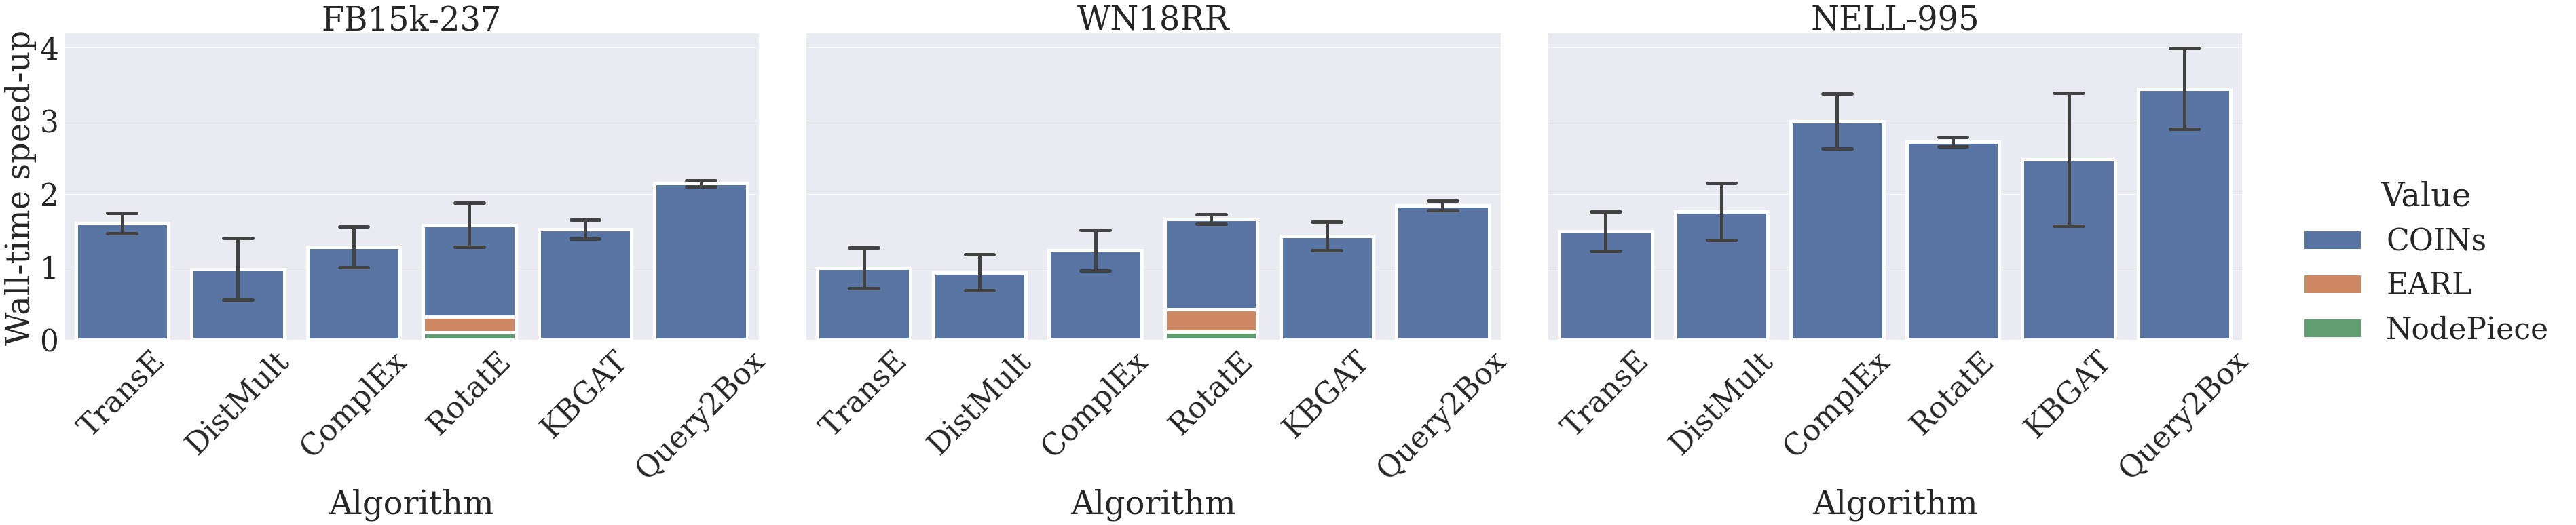

In [40]:
sns.set(context="paper", font="serif", font_scale=5, style="darkgrid")
plot_data = pd.concat([
    test_logs.loc[test_logs.Checkpoint=="best", ["Seed", "Dataset", "Algorithm", "Value", "TestTime"]],
    test_logs_baseline_2.loc[test_logs_baseline_2.Checkpoint=="best", ["Seed", "Dataset", "Algorithm", "Value", "TestTime"]],
    test_logs_baseline_3
])
for dataset in datasets_names:
    for alg in algs_names:
        for value in ["Baseline", "COINs"]:
            plot_data.loc[(plot_data.Dataset == dataset) 
                          & (plot_data.Algorithm == alg)
                          & (plot_data.Value == value), "Seed"] = range(5 if alg != "q2b" else 3)
plot_data_coins = plot_data[plot_data.Value != "Baseline"].set_index(["Seed", "Dataset", "Algorithm", "Value"]).TestTime
plot_data_baseline = plot_data[plot_data.Value == "Baseline"].set_index(["Seed", "Dataset", "Algorithm"]).TestTime
plot_data = plot_data_baseline / plot_data_coins
plot_data = plot_data.reindex(list(datasets_names.keys()), level=1)
plot_data = plot_data.reindex(list(algs_names.keys()), level=2)
plot_data = plot_data.reset_index()
plot_data.Dataset = plot_data.Dataset.map(datasets_names)
plot_data.Algorithm = plot_data.Algorithm.map(algs_names)
plot_data = pd.concat([pd.DataFrame([[0, "FB15k-237", "TransE", "NodePiece", None], 
                                     [0, "FB15k-237", "TransE", "EARL", None]], columns=plot_data.columns), 
                       plot_data])
plot_data = plot_data.set_index(["Seed", "Dataset", "Algorithm", "Value"]).reindex(["COINs", "EARL", "NodePiece"], level=3)
plot_data = plot_data.reset_index()

w, h = 16, 12
plt.figure(figsize=(3 * w, h))
g = sns.catplot(x="Algorithm", y="TestTime", hue="Value", col="Dataset", data=plot_data,
                kind="bar", ci="sd", dodge=False,
                capsize=0.25, errwidth=5, linewidth=5,
                height=h, aspect=w / h, facet_kws={"legend_out": True})
for dataset, ax in g.axes_dict.items():
    ax.set_title(dataset)
    plt.setp(ax.collections, sizes=[500])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylabel("Wall-time speed-up")
for lh in g.legend.get_lines():
    lh.set_linewidth(5)
g.tight_layout()
plt.savefig("graph_completion/results/acceleration_wall.pdf", format="pdf")

## Feasibility plots

In [41]:
plot_test_ranks_2 = plot_test_ranks.assign(
    Statistic=plot_test_ranks.CommunityWeight * (1 + plot_test_ranks.RelativeError) / plot_test_ranks.Acceleration,
    NodeStatistic=plot_test_ranks.CommunityWeight * (1 + plot_test_ranks.NodeRelativeError) / plot_test_ranks.Acceleration
)
plot_test_ranks_2 = plot_test_ranks_2.drop(columns=["CommunityWeight", "Rank", "NodeRank",
                                                    "Acceleration", "RelativeError", "NodeRelativeError"])
plot_test_ranks_2 = plot_test_ranks_2.groupby(level=[1, 2, 3]).sum()
plot_test_logs_baseline_2 = plot_test_logs_baseline.reset_index()
plot_test_logs_baseline_2 = plot_test_logs_baseline_2.assign(
    BaselineExpectation=plot_test_logs_baseline_2.Dataset.map(V_size) * plot_test_logs_baseline_2.MR
).set_index(["Dataset", "Algorithm"])
plot_test_ranks_2 = plot_test_ranks_2.join(plot_test_logs_baseline_2).reset_index()

<Figure size 2808x1152 with 0 Axes>

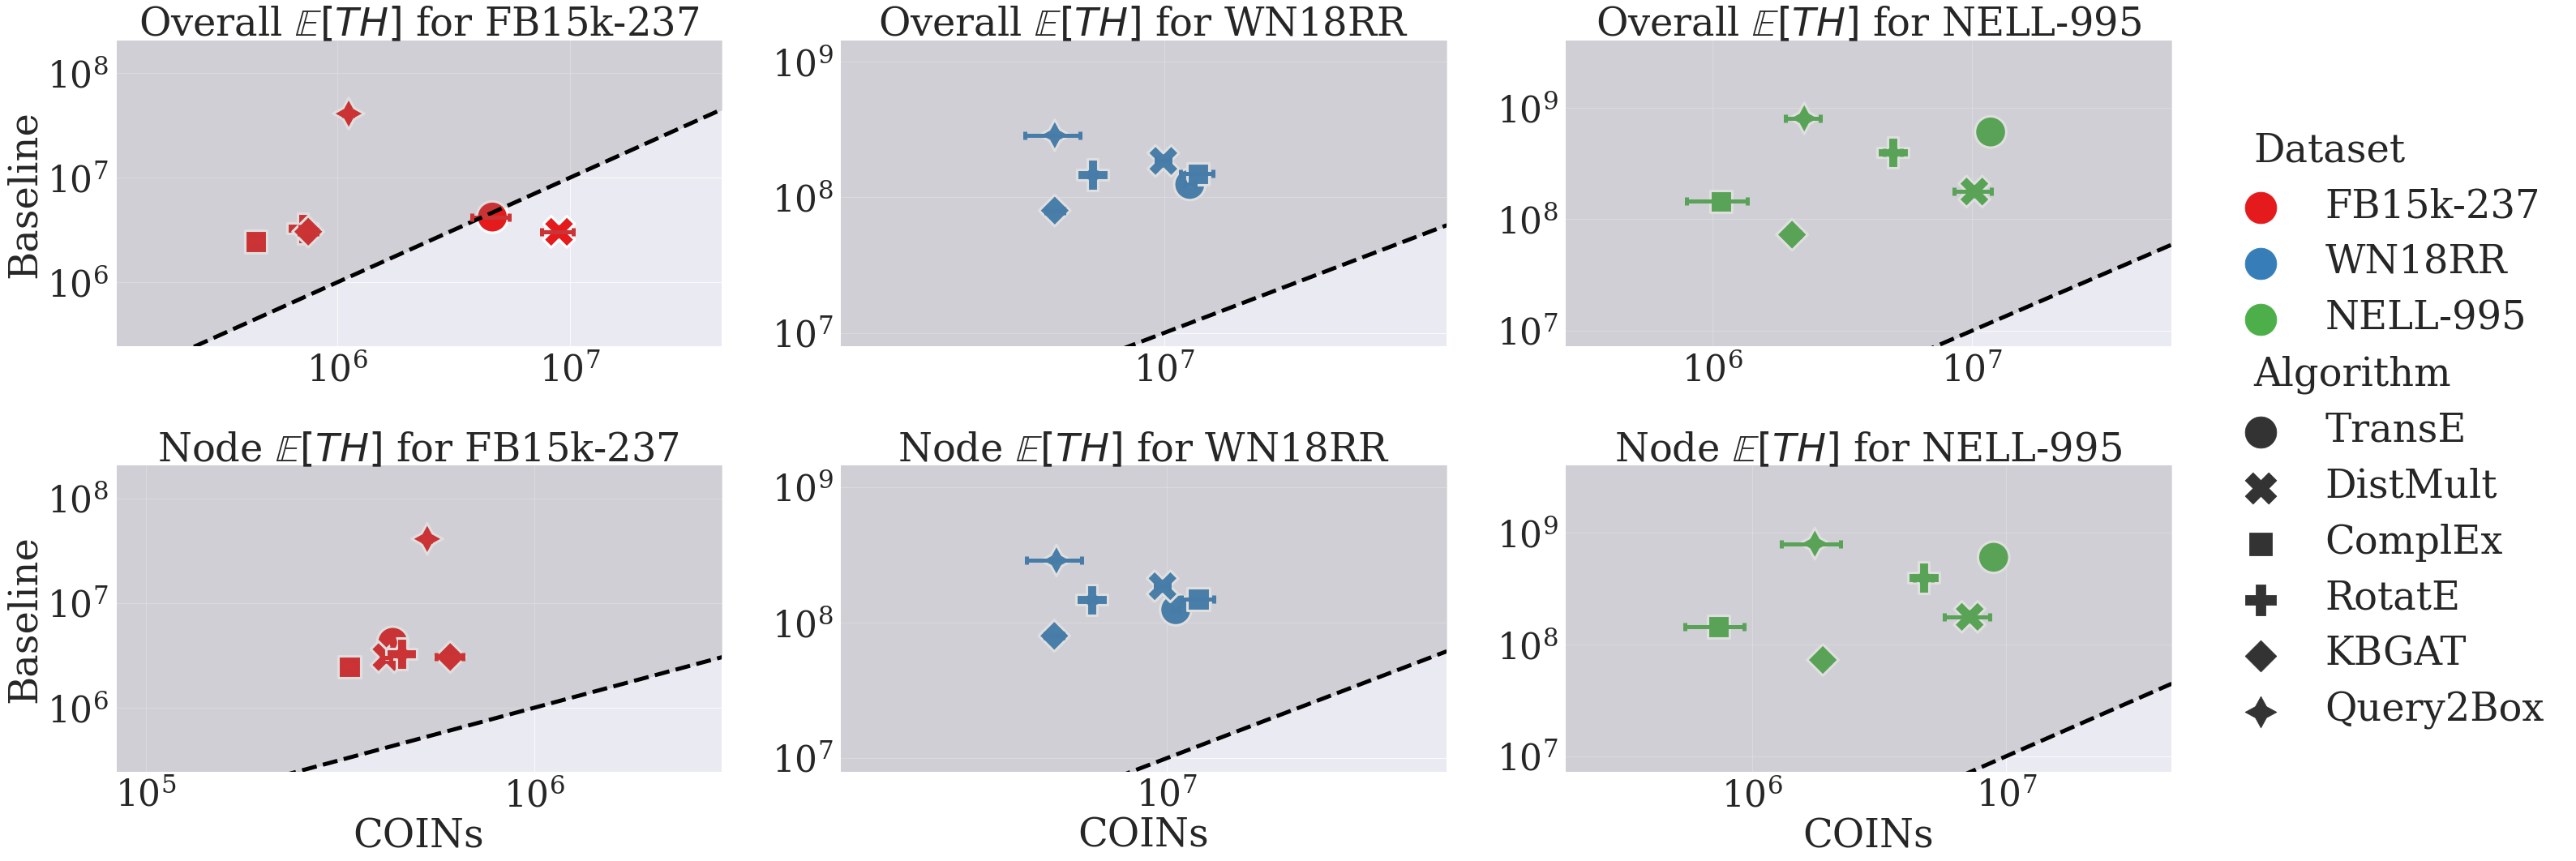

In [42]:
sns.set(context="paper", font="serif", font_scale=5, style="darkgrid")
plot_data = plot_test_ranks_2.rename(
    columns={"BaselineExpectation": "Baseline", "Expectation": "Overall", "NodeExpectation": "Node"}
).melt(id_vars=["Seed", "Dataset", "Algorithm", "Baseline"],
       value_vars=["Overall", "Node"],
       var_name="Value", value_name="COINs")
plot_data_std = plot_data.groupby(["Dataset", "Algorithm", "Value"])[["COINs", "Baseline"]].std()
plot_data_std = plot_data_std.reindex(list(datasets_names.keys()), level=0)
plot_data_std = plot_data_std.reindex(list(algs_names.keys()), level=1)
plot_data_std = plot_data_std.reindex(["Overall", "Node"], level=2)
plot_data_std = plot_data_std.reset_index()
plot_data_std.Dataset = plot_data_std.Dataset.map(datasets_names)
plot_data_std.Algorithm = plot_data_std.Algorithm.map(algs_names)
plot_data = plot_data.groupby(["Dataset", "Algorithm", "Value"])[["COINs", "Baseline"]].mean()
plot_data = plot_data.reindex(list(datasets_names.keys()), level=0)
plot_data = plot_data.reindex(list(algs_names.keys()), level=1)
plot_data = plot_data.reindex(["Overall", "Node"], level=2)
plot_data = plot_data.reset_index()
plot_data.Dataset = plot_data.Dataset.map(datasets_names)
plot_data.Algorithm = plot_data.Algorithm.map(algs_names)
x_boundary = np.geomspace(1e4, 1e8, 10000, endpoint=False)
y_boundary = x_boundary
w, h = 13, 8
plt.figure(figsize=(3 * w, 2 * h))
g = sns.relplot(x="COINs", y="Baseline", hue="Dataset", style="Algorithm",
                row="Value", col="Dataset", data=plot_data,
                palette="Set1", s=1500, kind="scatter",
                height=h, aspect=w / h, facet_kws={"legend_out": True, "sharex": False, "sharey": False})
dataset_color_map = {dataset_name: color for (_, dataset_name), color in zip(
    datasets_names.items(), sns.color_palette("Set1", n_colors=len(datasets_names), desat=0.75)
)}
for (value, dataset), ax in g.axes_dict.items():
    ax.set_title(fr"{value} $\mathbb{{E}}[T H]$ for {dataset}")
    ax.fill_between(x_boundary, y_boundary, 1e10, color="gray", alpha=0.25)
    ax.plot(x_boundary, y_boundary, color="black", linestyle="dashed", lw=5)
    mean_data = plot_data[(plot_data.Value == value) & (plot_data.Dataset == dataset)]
    std_data = plot_data_std[(plot_data_std.Value == value) & (plot_data_std.Dataset == dataset)]
    error_bar_colors = [dataset_color_map[dataset], ] * len(std_data)
    for x, y, xerr, yerr, ecolor in zip(mean_data.COINs, mean_data.Baseline,
                                        std_data.COINs, std_data.Baseline, error_bar_colors):
        ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt="none", ecolor=ecolor, elinewidth=5, capsize=5, capthick=5)
    ax.set_xlim(0.25*mean_data.COINs.min(), 5*mean_data.COINs.max())
    ax.set_ylim(1e-1*mean_data.Baseline.min(), 5*mean_data.Baseline.max())
    ax.set_xscale("log")
    ax.set_yscale("log")
for lh in g.legend.legendHandles:
    lh.set_sizes([1500])
g.tight_layout()
plt.savefig("graph_completion/results/feasibility.pdf", format="pdf")

<Figure size 3024x1152 with 0 Axes>

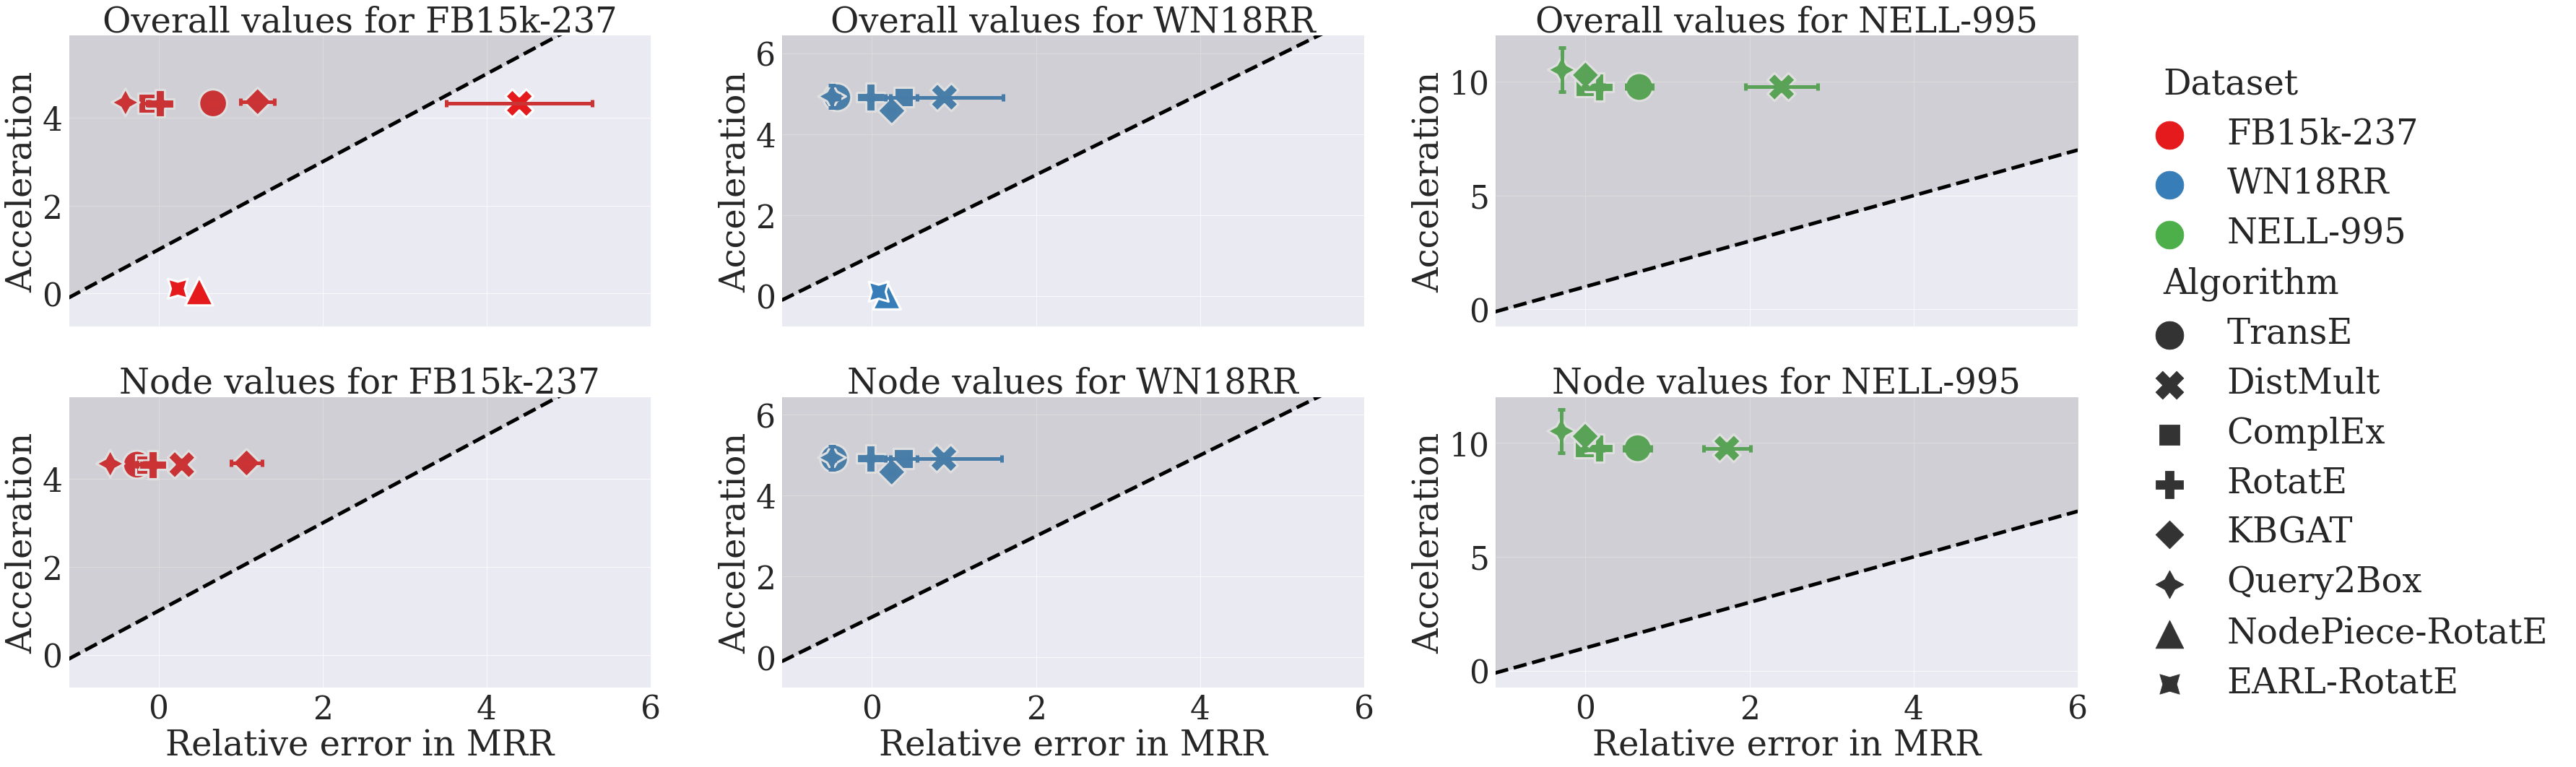

In [43]:
sns.set(context="paper", font="serif", font_scale=5, style="darkgrid")
plot_data = plot_test_logs.reset_index().rename(
    columns={"RelativeError": "Overall", "NodeRelativeError": "Node"}
).melt(id_vars=["Seed", "Dataset", "Algorithm", "Acceleration"],
       value_vars=["Overall", "Node"],
       var_name="Value", value_name="RelativeError")

plot_data_2 = nodepiece_earl_baselines[["Seed", "Dataset", "Algorithm", "Acceleration", "MRR"]]
plot_data_2 = plot_data_2.set_index(["Seed", "Dataset", "Algorithm"])
plot_data_2_baselines = plot_test_logs_baseline_mrr.loc[:, "rotate"]
plot_data_2_baselines = plot_data_2_baselines.reindex(list(datasets_names.keys()))
plot_data_2_baselines = plot_data_2_baselines.reset_index()
plot_data_2_baselines.Dataset = plot_data_2_baselines.Dataset.map(datasets_names)
plot_data_2_baselines = plot_data_2_baselines.set_index("Dataset").MRR
plot_data_2 = plot_data_2.assign(Value="Overall", 
                                 RelativeError=(plot_data_2_baselines - plot_data_2.MRR) / plot_data_2.MRR)
plot_data_2 = plot_data_2.drop(columns="MRR")

plot_data_std = plot_data.groupby(["Dataset", "Algorithm", "Value"])[["Acceleration", "RelativeError"]].std()
plot_data_std = plot_data_std.reindex(list(datasets_names.keys()), level=0)
plot_data_std = plot_data_std.reindex(list(algs_names.keys()), level=1)
plot_data_std = plot_data_std.reindex(["Overall", "Node"], level=2)
plot_data_std = plot_data_std.reset_index()
plot_data_std.Dataset = plot_data_std.Dataset.map(datasets_names)
plot_data_std.Algorithm = plot_data_std.Algorithm.map(algs_names)
plot_data = plot_data.groupby(["Dataset", "Algorithm", "Value"])[["Acceleration", "RelativeError"]].mean()
plot_data = plot_data.reindex(list(datasets_names.keys()), level=0)
plot_data = plot_data.reindex(list(algs_names.keys()), level=1)
plot_data = plot_data.reindex(["Overall", "Node"], level=2)
plot_data = plot_data.reset_index()
plot_data.Dataset = plot_data.Dataset.map(datasets_names)
plot_data.Algorithm = plot_data.Algorithm.map(algs_names)
plot_data = pd.concat([plot_data, plot_data_2.reset_index()], ignore_index=True)

x_boundary = np.linspace(-1.1, 6, 10000, endpoint=False)
y_boundary = 1 + x_boundary
w, h = 14, 8
plt.figure(figsize=(3 * w, 2 * h))
g = sns.relplot(x="RelativeError", y="Acceleration", hue="Dataset", style="Algorithm",
                row="Value", col="Dataset", data=plot_data,
                palette="Set1", s=1500, kind="scatter",
                height=h, aspect=w / h, facet_kws={"legend_out": True, "sharex": True, "sharey": False})
dataset_color_map = {dataset_name: color for (_, dataset_name), color in zip(
    datasets_names.items(), sns.color_palette("Set1", n_colors=len(datasets_names), desat=0.75)
)}
for (value, dataset), ax in g.axes_dict.items():
    ax.set_title(f"{value} values for {dataset}")
    ax.fill_between(x_boundary, y_boundary, 12.1, color="gray", alpha=0.25)
    ax.plot(x_boundary, y_boundary, color="black", linestyle="dashed", lw=5)
    mean_data = plot_data[(plot_data.Value == value) & (plot_data.Dataset == dataset)]
    std_data = plot_data_std[(plot_data_std.Value == value) & (plot_data_std.Dataset == dataset)]
    error_bar_colors = [dataset_color_map[dataset], ] * len(std_data)
    for x, y, xerr, yerr, ecolor in zip(mean_data.RelativeError, mean_data.Acceleration,
                                        std_data.RelativeError, std_data.Acceleration, error_bar_colors):
        ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt="none", ecolor=ecolor, elinewidth=5, capsize=5, capthick=5)
    ax.set_xlabel("Relative error in MRR")
    ax.set_ylabel("Acceleration")
    ax.set_xlim(-1.1, 6)
    ax.set_ylim(-0.75, mean_data.Acceleration.max()+1.5)
for lh in g.legend.legendHandles:
    lh.set_sizes([1500])
g.tight_layout()
plt.savefig("graph_completion/results/feasibility_2.pdf", format="pdf")

<Figure size 1684.8x597.6 with 0 Axes>

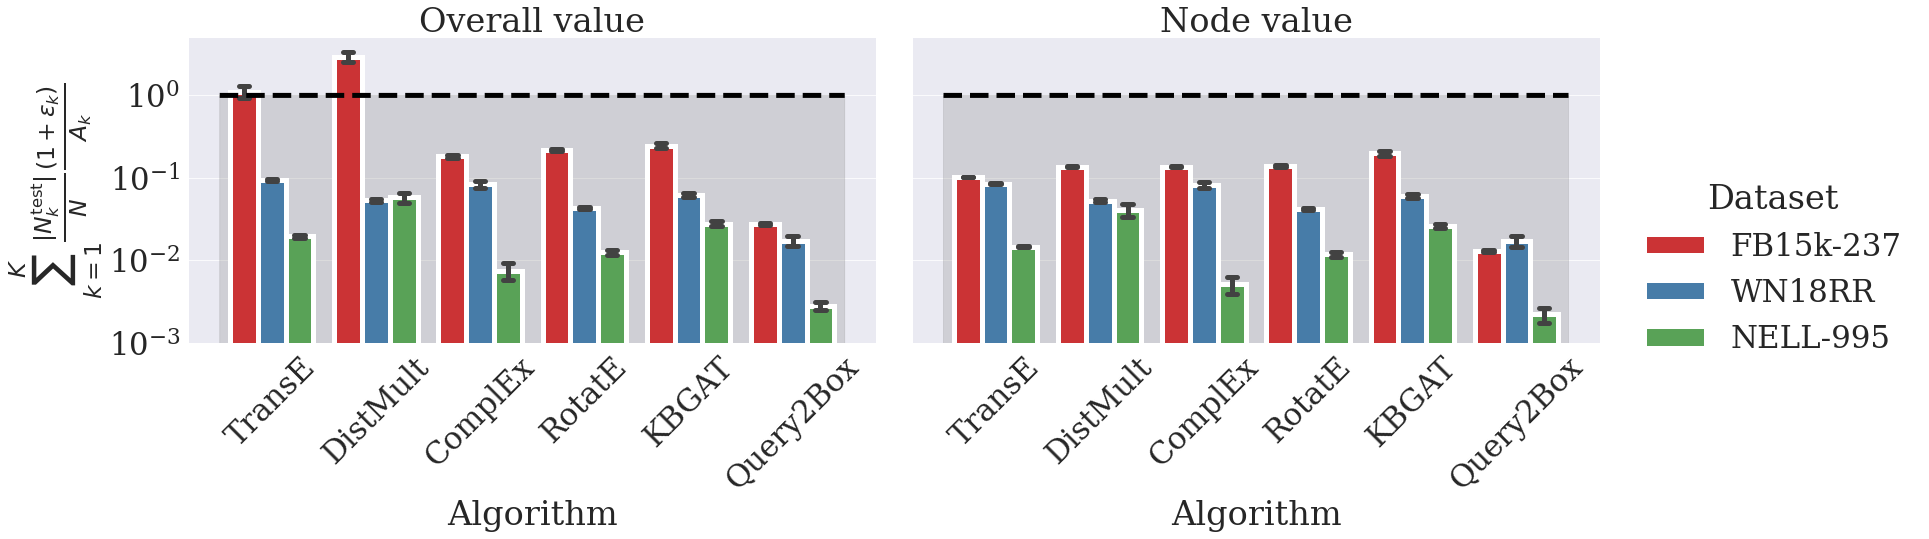

In [44]:
sns.set(context="paper", font="serif", font_scale=3.5, style="darkgrid")
plot_data = plot_test_ranks_2.rename(
    columns={"Statistic": "Overall", "NodeStatistic": "Node"}
).melt(id_vars=["Seed", "Dataset", "Algorithm"],
       value_vars=["Overall", "Node"],
       var_name="Value", value_name="Statistic")
plot_data = plot_data.set_index(["Dataset", "Algorithm", "Value", "Seed"])
plot_data = plot_data.reindex(list(datasets_names.keys()), level=0)
plot_data = plot_data.reindex(list(algs_names.keys()), level=1)
plot_data = plot_data.reindex(["Overall", "Node"], level=2)
plot_data = plot_data.reset_index()
plot_data.Dataset = plot_data.Dataset.map(datasets_names)
plot_data.Algorithm = plot_data.Algorithm.map(algs_names)
x_boundary = np.linspace(-0.5, 5.5, 10000, endpoint=False)
w, h = 11.7, 8.3
plt.figure(figsize=(2 * w, h))
g = sns.catplot(x="Algorithm", y="Statistic", hue="Dataset",
                col="Value", data=plot_data,
                palette="Set1", kind="bar", ci="sd",
                capsize=0.1, errwidth=5, linewidth=5,
                height=h, aspect=w / h, facet_kws={"legend_out": True})
dataset_color_map = {dataset_name: color for (_, dataset_name), color in zip(
    datasets_names.items(), sns.color_palette("Set1", n_colors=len(datasets_names), desat=0.75)
)}
for value, ax in g.axes_dict.items():
    ax.set_title(f"{value} value")
    plt.setp(ax.collections, sizes=[500])
    ax.fill_between(x_boundary, np.zeros_like(x_boundary), 1, color="gray", alpha=0.25)
    ax.plot(x_boundary, np.ones_like(x_boundary), color="black", linestyle="dashed", lw=5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylim(1e-3, 5)
    ax.set_yscale("log")
    ax.set_ylabel(r"$\sum_{k=1}^{K}{\frac{|N_k^{\mathrm{test}}|}{N} \frac{(1 + \varepsilon_k)}{A_k}}$")
for lh in g.legend.get_lines():
    lh.set_linewidth(5)
g.tight_layout()
plt.savefig("graph_completion/results/feasibility_statistic.pdf", format="pdf")

<Figure size 3024x1152 with 0 Axes>

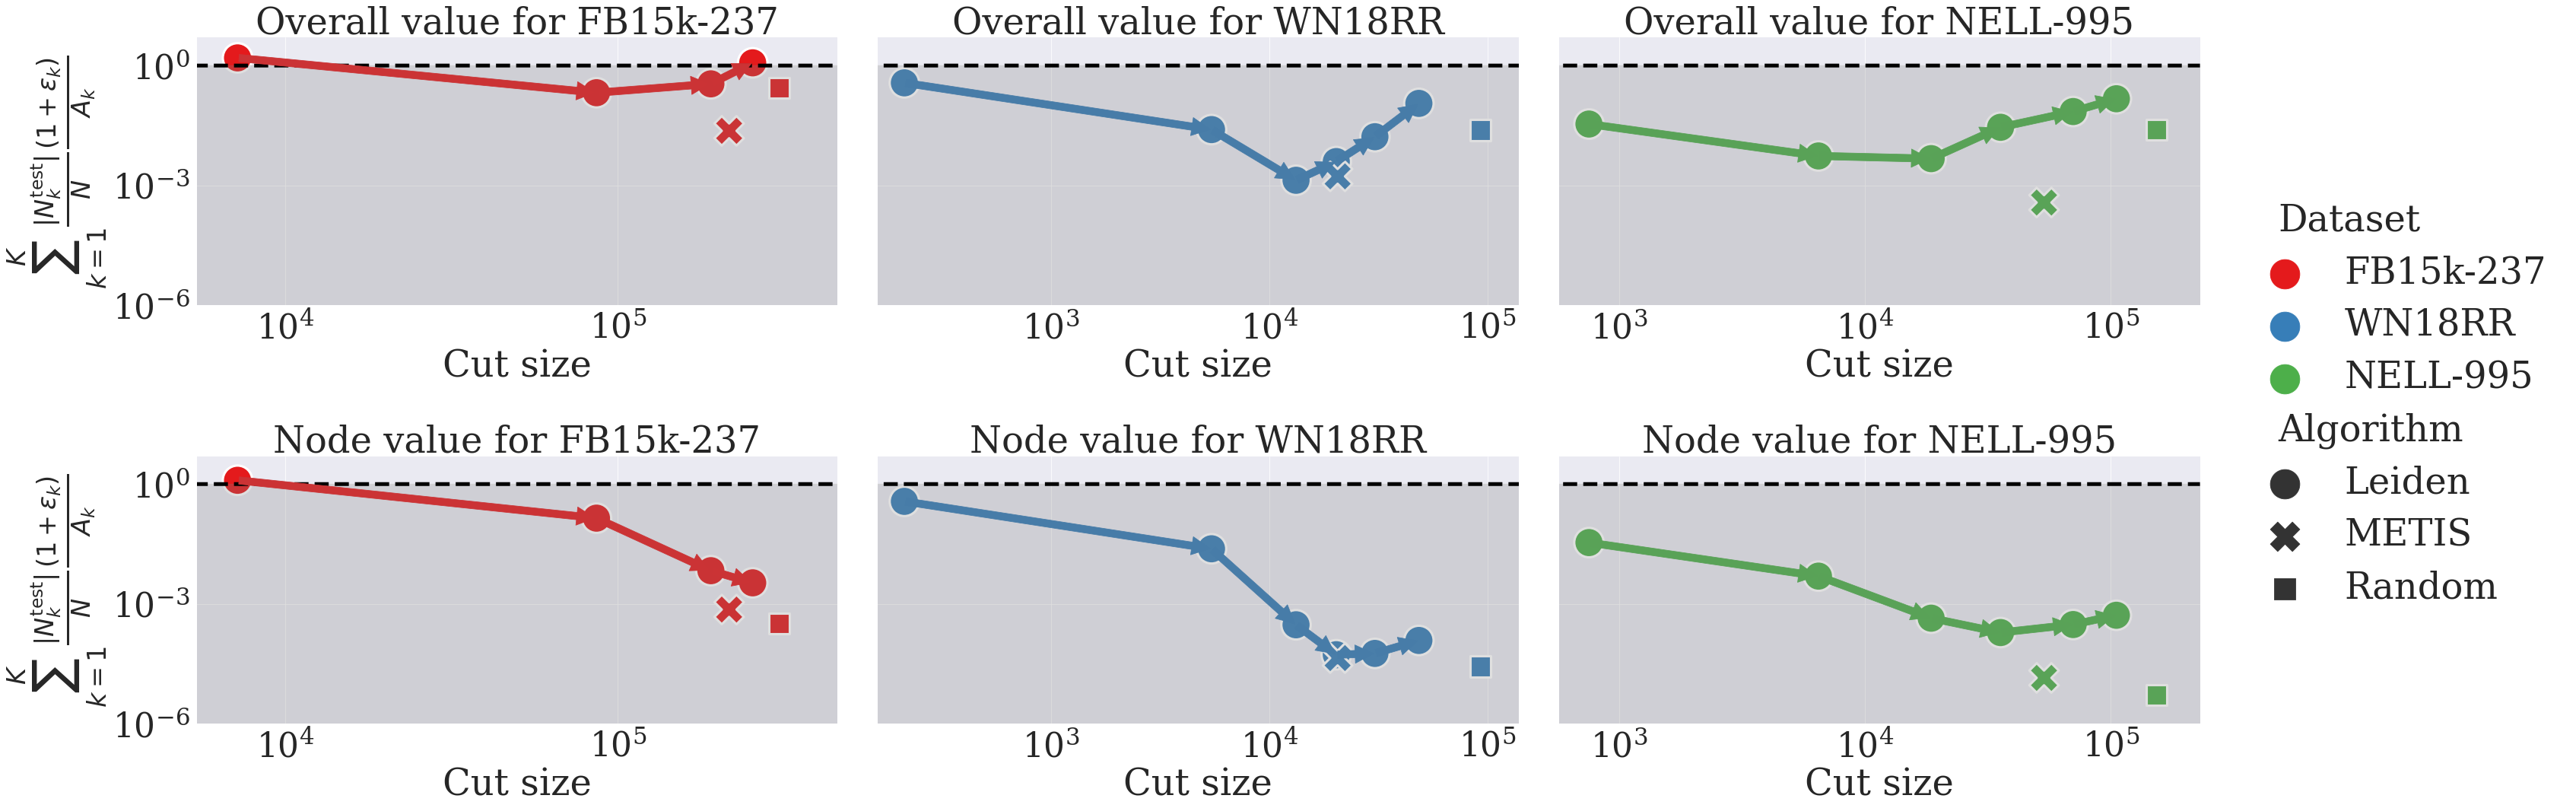

In [45]:
sns.set(context="paper", font="serif", font_scale=5, style="darkgrid")
plot_data = plot_test_ranks_extra.rename(
    columns={"Statistic": "Overall", "NodeStatistic": "Node"}
).melt(id_vars=["Seed", "Dataset", "Algorithm", "CommunityMethod", "LeidenResolution"],
       value_vars=["Overall", "Node"],
       var_name="Value", value_name="Statistic").astype({"LeidenResolution": float})
plot_data = pd.concat((
    plot_data.loc[plot_data.CommunityMethod == "leiden"].merge(plot_data_leiden_extra,
                                                               on=["Dataset", "LeidenResolution"]),
    plot_data.loc[plot_data.CommunityMethod == "metis"].merge(plot_data_metis, on="Dataset"),
    plot_data.loc[plot_data.CommunityMethod == "random"].merge(
        plot_data_random.groupby("Dataset", as_index=False).mean(),
        on="Dataset")
), ignore_index=True)
plot_data = plot_data.set_index(
    ["Dataset", "CommunityMethod", "LeidenResolution", "Value"]
).sort_index().drop(columns=["Algorithm", ])
plot_data = plot_data.sort_index(level=[0, 1, 2])
plot_data = plot_data.reindex(list(datasets_names.keys()), level=0)
plot_data = plot_data.reindex(["leiden", "metis", "random"], level=1)
plot_data = plot_data.reindex(["Overall", "Node"], level=3)
plot_data = plot_data.reset_index()
plot_data.Dataset = plot_data.Dataset.map(datasets_names)
plot_data.CommunityMethod = plot_data.CommunityMethod.map(
    {"leiden": "Leiden", "metis": "METIS", "random": "Random"})
plot_data = plot_data.rename(columns={"CommunityMethod": "Algorithm"})
x_boundary = np.linspace(-1e1, 1e6, 10000, endpoint=False)
w, h = 14, 8
plt.figure(figsize=(3 * w, 2 * h))
g = sns.relplot(x="CutSize", y="Statistic", hue="Dataset", style="Algorithm",
                row="Value", col="Dataset", data=plot_data,
                palette="Set1", kind="scatter", s=1500,
                height=h, aspect=w / h, facet_kws={"sharex": False, "sharey": True, "legend_out": True})
for (value, dataset), ax in g.axes_dict.items():
    ax.set_title(f"{value} value for {dataset}")
    leiden_curves = plot_data[(plot_data.Algorithm == "Leiden") & (plot_data.Value == value) & (plot_data.Dataset == dataset)]
    for i in range(len(leiden_curves) - 1):
        ax.annotate("", xytext=(leiden_curves.iloc[i].CutSize, leiden_curves.iloc[i].Statistic),
                    xy=(leiden_curves.iloc[i + 1].CutSize, leiden_curves.iloc[i + 1].Statistic),
                    arrowprops={"color": dataset_color_map[dataset], 
                                "arrowstyle": "simple"})
    plot_data_piece = plot_data[(plot_data.Value == value) & (plot_data.Dataset == dataset)]
    ax.fill_between(x_boundary, np.zeros_like(x_boundary), 1, color="gray", alpha=0.25)
    ax.plot(x_boundary, np.ones_like(x_boundary), color="black", linestyle="dashed", lw=5)
    ax.set_xlim(0.75*plot_data_piece.CutSize.min(), 1.5*plot_data_piece.CutSize.max())
    ax.set_ylim(1e-6, 5)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Cut size")
    ax.set_ylabel(r"$\sum_{k=1}^{K}{\frac{|N^{\mathrm{test}}_{k}|}{N} \frac{(1+\varepsilon_k)}{A_k}}$")
for lh in g.legend.legendHandles:
    lh.set_sizes([1500])
g.tight_layout()
plt.savefig("graph_completion/results/feasibility_extra.pdf", format="pdf")

<Figure size 3456x1440 with 0 Axes>

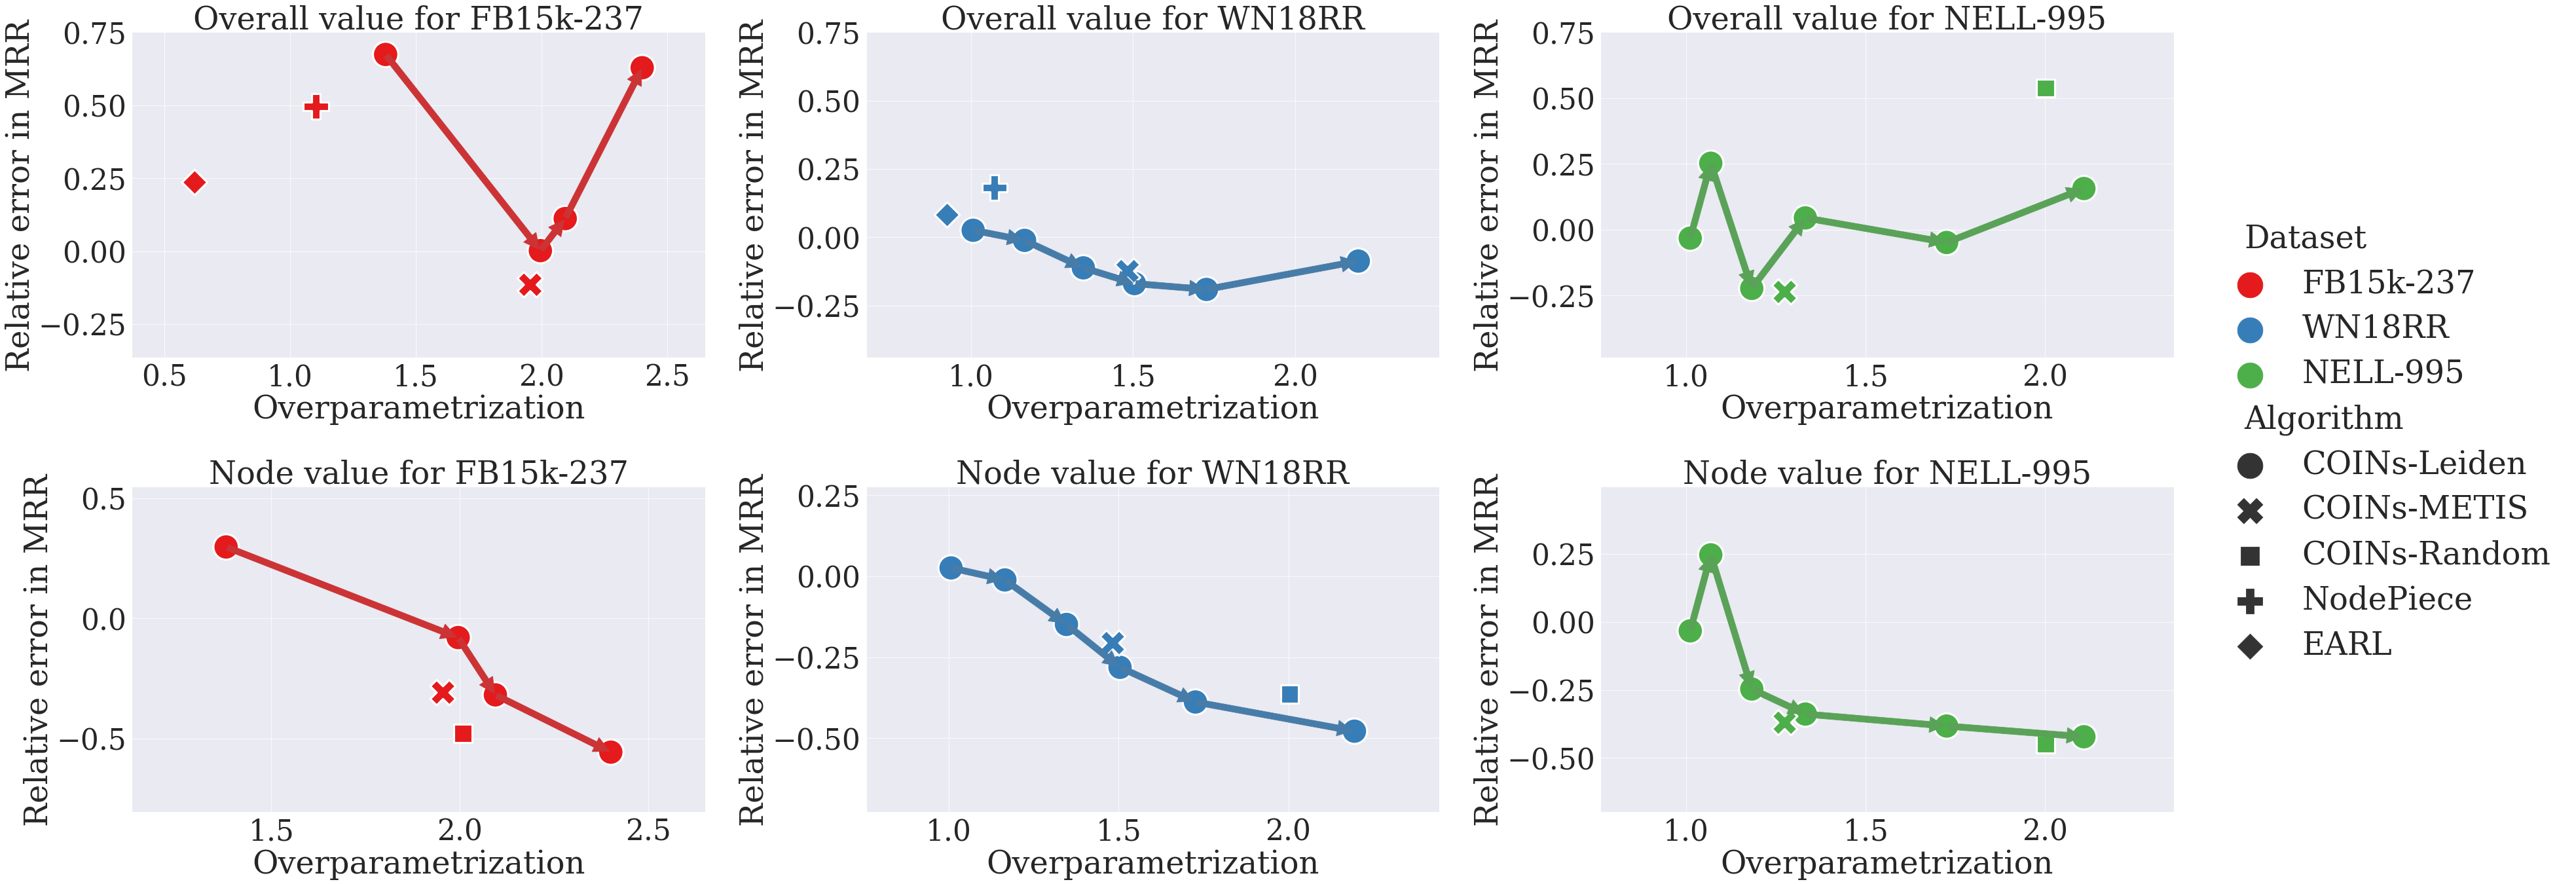

In [46]:
sns.set(context="paper", font="serif", font_scale=5, style="darkgrid")
plot_data = plot_test_logs_extra.rename(
    columns={"RelativeError": "Overall", "NodeRelativeError": "Node"}
).melt(id_vars=["Seed", "Dataset", "CommunityMethod", "LeidenResolution"],
       value_vars=["Overall", "Node"],
       var_name="Value", value_name="RelativeError").astype({"LeidenResolution": float})
plot_data = pd.concat((
    plot_data.loc[plot_data.CommunityMethod == "leiden"].merge(plot_data_leiden_extra,
                                                               on=["Dataset", "LeidenResolution"]),
    plot_data.loc[plot_data.CommunityMethod == "metis"].merge(plot_data_metis, on="Dataset"),
    plot_data.loc[plot_data.CommunityMethod == "random"].merge(
        plot_data_random.groupby("Dataset", as_index=False).mean(),
        on="Dataset")
), ignore_index=True)
plot_data = plot_data.set_index(
    ["Dataset", "CommunityMethod", "LeidenResolution", "Value"]
).sort_index()
plot_data = plot_data.sort_index(level=[0, 1, 2])
plot_data = plot_data.reindex(list(datasets_names.keys()), level=0)
plot_data = plot_data.reindex(["leiden", "metis", "random"], level=1)
plot_data = plot_data.reindex(["Overall", "Node"], level=3)
plot_data = plot_data.reset_index()
plot_data.Dataset = plot_data.Dataset.map(datasets_names)
plot_data.CommunityMethod = plot_data.CommunityMethod.map(
    {"leiden": "COINs-Leiden", "metis": "COINs-METIS", "random": "COINs-Random"})
plot_data = plot_data.rename(columns={"CommunityMethod": "Algorithm"})
plot_data_2 = nodepiece_earl_baselines[["Seed", "Dataset", "Algorithm", "Acceleration", "Overparametrization", "MRR"]]
plot_data_2 = plot_data_2.assign(Algorithm=plot_data_2.Algorithm.str.replace("-RotatE", ""))
plot_data_2 = plot_data_2.set_index(["Seed", "Dataset", "Algorithm"])
plot_data_2_baselines = plot_test_logs_baseline_mrr.loc[:, "rotate"]
plot_data_2_baselines = plot_data_2_baselines.reindex(list(datasets_names.keys()))
plot_data_2_baselines = plot_data_2_baselines.reset_index()
plot_data_2_baselines.Dataset = plot_data_2_baselines.Dataset.map(datasets_names)
plot_data_2_baselines = plot_data_2_baselines.set_index("Dataset").MRR
plot_data_2 = plot_data_2.assign(Value="Overall", 
                                 RelativeError=(plot_data_2_baselines - plot_data_2.MRR) / plot_data_2.MRR)
plot_data_2 = plot_data_2.drop(columns="MRR")
plot_data = pd.concat([plot_data, plot_data_2.reset_index()], ignore_index=True)

w, h = 16, 10
plt.figure(figsize=(3 * w, 2 * h))
g = sns.relplot(x="Overparametrization", y="RelativeError", hue="Dataset", style="Algorithm",
                row="Value", col="Dataset", data=plot_data,
                palette="Set1", kind="scatter", s=1500,
                height=h, aspect=w / h, facet_kws={"sharex": False, "sharey": False, "legend_out": True})
for (value, dataset), ax in g.axes_dict.items():
    ax.set_title(f"{value} value for {dataset}")
    leiden_curves = plot_data[(plot_data.Algorithm == "COINs-Leiden") & (plot_data.Value == value) & (plot_data.Dataset == dataset)]
    for i in range(len(leiden_curves) - 1):
        ax.annotate("", xytext=(leiden_curves.iloc[i].Overparametrization, leiden_curves.iloc[i].RelativeError),
                    xy=(leiden_curves.iloc[i + 1].Overparametrization, leiden_curves.iloc[i + 1].RelativeError),
                    arrowprops={"arrowstyle": "simple",
                                "color": dataset_color_map[dataset]})
    plot_data_piece = plot_data[(plot_data.Value == value) & (plot_data.Dataset == dataset)]
    ax.set_xlim(plot_data_piece.Overparametrization.min()-0.25, plot_data_piece.Overparametrization.max()+0.25)
    ax.set_ylim(plot_data_piece.RelativeError.min()-0.25, min(plot_data_piece.RelativeError.max()+0.25, 0.75))
    ax.set_xlabel("Overparametrization")
    ax.set_ylabel("Relative error in MRR")
for lh in g.legend.legendHandles:
    lh.set_sizes([1500])
g.tight_layout()
plt.savefig("graph_completion/results/feasibility_extra_2.pdf", format="pdf")

## Convergence plots

<Figure size 5054.4x1195.2 with 0 Axes>

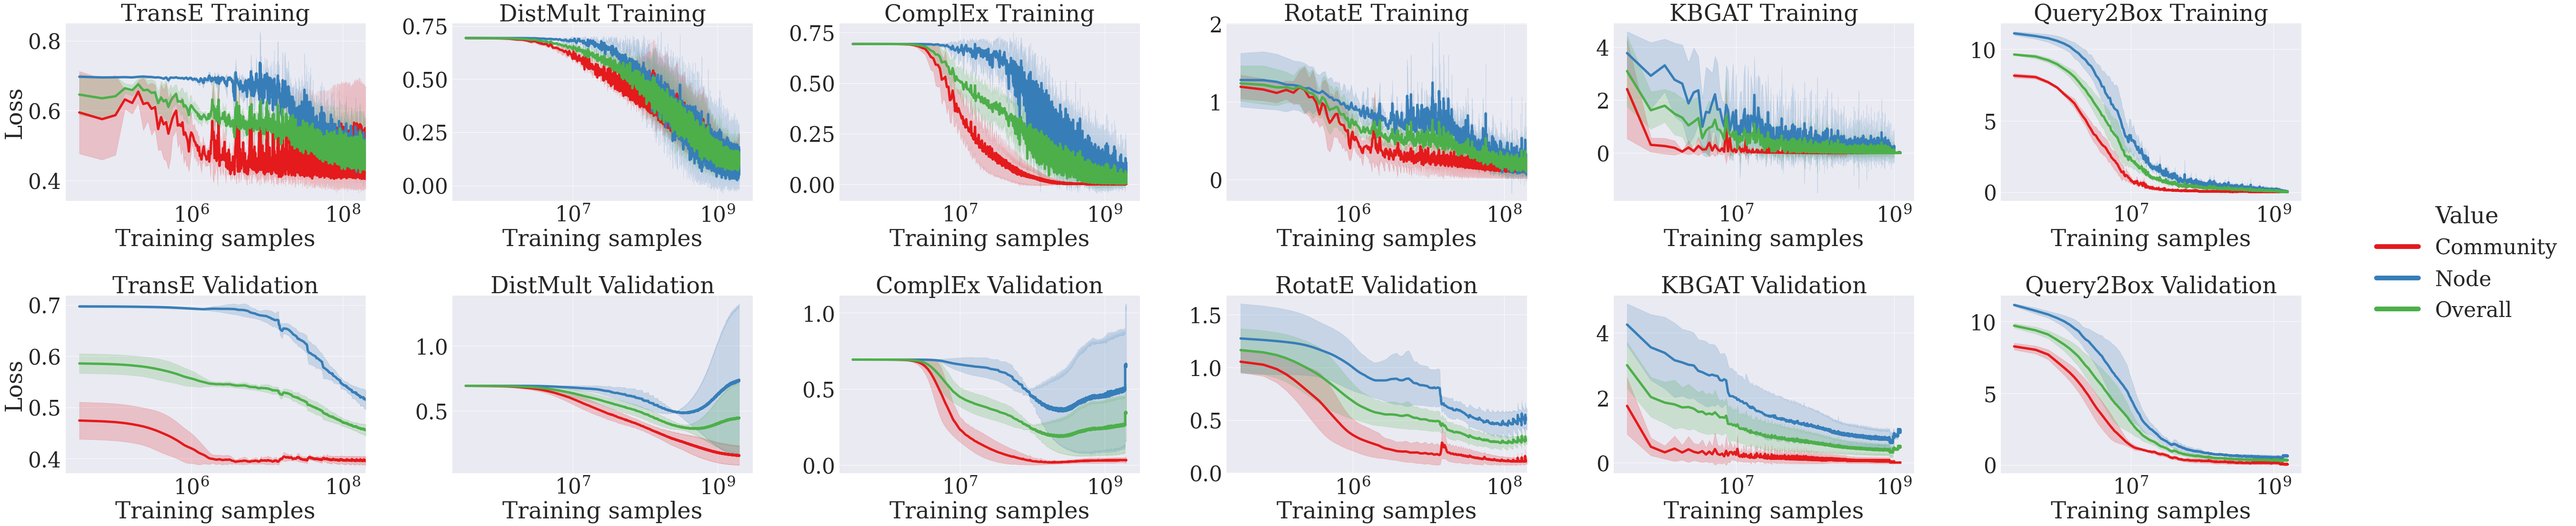

In [47]:
sns.set(context="paper", font="serif", font_scale=5, style="darkgrid")
plot_data_train = train_logs[
    ["Seed", "Dataset", "Algorithm", "NumSamples", "TrainComLoss", "TrainNodeLoss", "TrainLoss"]
]
plot_data_train = plot_data_train.rename(
    columns={"TrainComLoss": "Community", "TrainNodeLoss": "Node", "TrainLoss": "Overall"}
).melt(id_vars=["Seed", "Dataset", "Algorithm", "NumSamples"], value_vars=["Community", "Node", "Overall"],
       var_name="Value", value_name="Loss").assign(Subset="Training")
plot_data_valid = train_logs[
    ["Seed", "Dataset", "Algorithm", "NumSamples", "ValComLoss", "ValNodeLoss", "ValLoss"]
]
plot_data_valid = plot_data_valid.rename(
    columns={"ValComLoss": "Community", "ValNodeLoss": "Node", "ValLoss": "Overall"}
).melt(id_vars=["Seed", "Dataset", "Algorithm", "NumSamples"], value_vars=["Community", "Node", "Overall"],
       var_name="Value", value_name="Loss").assign(Subset="Validation")
plot_data = pd.concat((plot_data_train, plot_data_valid), ignore_index=True)
plot_data = plot_data.set_index(["Dataset", "Algorithm", "NumSamples", "Value", "Subset", "Seed"])
plot_data = plot_data.reindex(list(datasets_names.keys()), level=0)
plot_data = plot_data.reindex(list(algs_names.keys()), level=1)
plot_data = plot_data.reset_index()
w, h = 11.7, 8.3
plt.figure(figsize=(6 * w, 2 * h))
g = sns.relplot(x="NumSamples", y="Loss", hue="Value",
                row="Subset", col="Algorithm", data=plot_data,
                palette="Set1", linewidth=5, kind="line", ci="sd",
                height=h, aspect=w / h, facet_kws={"sharex": False, "sharey": False, "legend_out": True})
for (subset, algorithm_key), ax in g.axes_dict.items():
    ax.set_title(f"{algs_names[algorithm_key]} {subset}")
    ax.set_xscale("log")
    if algorithm_key in ["transe", "rotate"]:
        ax.set_xlim(right=2e8)
    ax.set_xlabel("Training samples")
for lh in g.legend.get_lines():
    lh.set_linewidth(10)
g.tight_layout()
plt.savefig("graph_completion/results/convergence.pdf", format="pdf")